In [1]:
#!pip install hyperopt datawig lightgbm pyod xgboost mlxtend category-encoders tensorflow

### Download the Data

In [1]:
import os
import pandas as pd
import requests

# dataset is located in current directory
HOUSING_PATH = os.getcwd()

# function to load training dataset


def load_housing_data(filename="train.csv"):
    import numpy as np
    csv_path = os.path.join(HOUSING_PATH, filename)
    df = pd.read_csv(csv_path, dtype={'GarageYrBlt': np.float32, 'YearBuilt': np.float32, 'YrSold': np.float32, 'YearRemodAdd': np.float32,
                                      'LotFrontage': np.float32})

    return df

In [2]:
# Read files
train = load_housing_data('train.csv')
test = load_housing_data('test.csv')

# Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

# Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis=1, inplace=True)
test.drop("Id", axis=1, inplace=True)

## Drop outliers records

In [3]:
# From EDA obvious outliers
train = train[train.GrLivArea < 4500]
train.reset_index(drop=True, inplace=True)

outliers = [30, 88, 462, 631, 1322]
train = train.drop(train.index[outliers])

# typo in test set:
test.loc[test['GarageYrBlt']>test['YrSold'], 'GarageYrBlt'] = test[test['GarageYrBlt']>test['YrSold']]['YearBuilt']

In [4]:
max(test['GarageYrBlt'])

2010.0

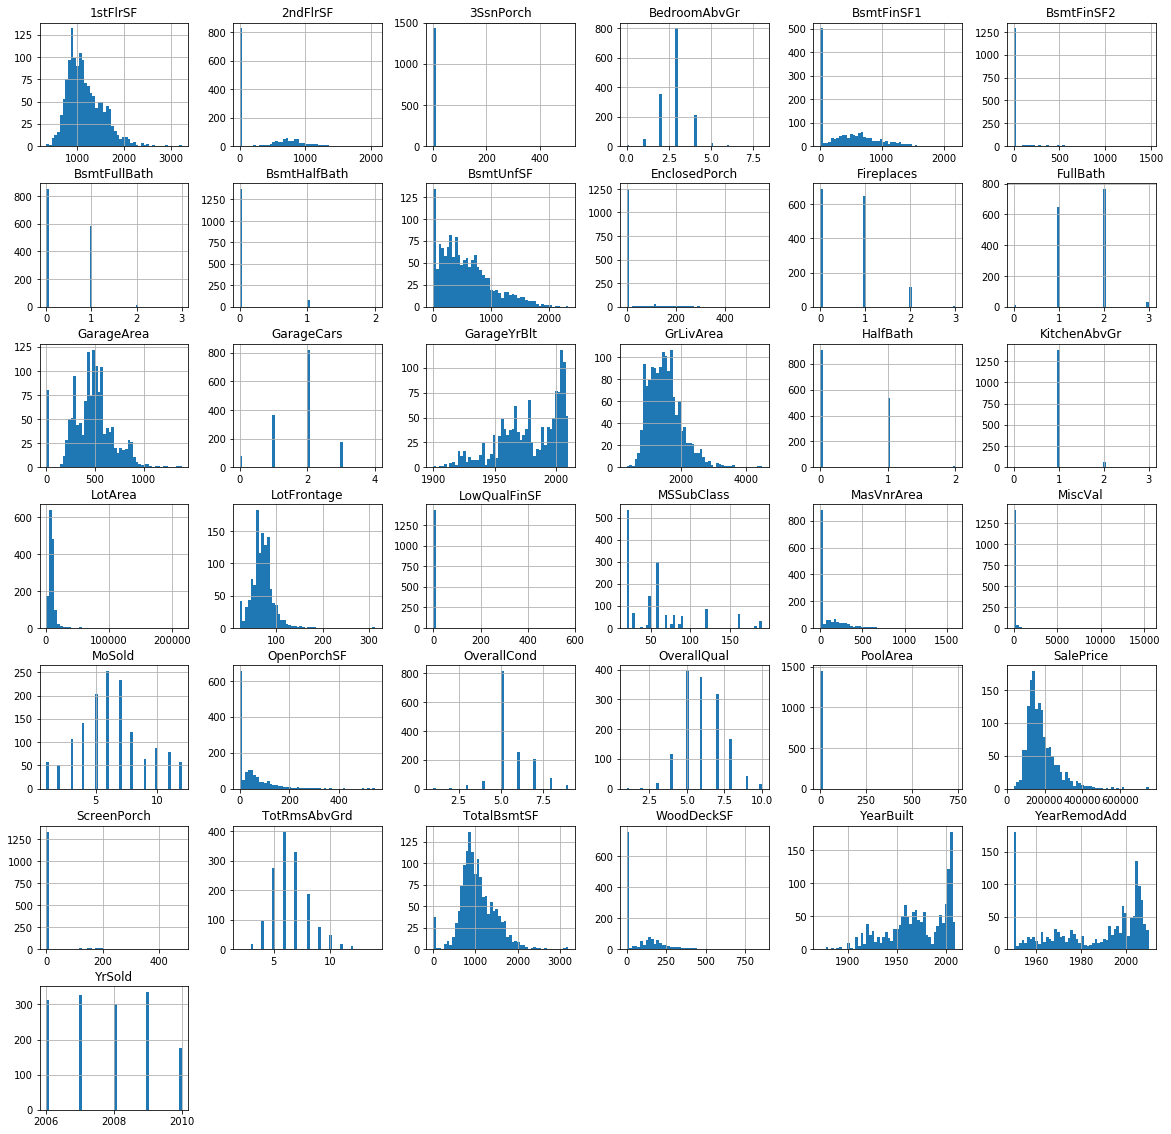

In [5]:
# display histogram for each numerical attribute
import matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt
train.hist(bins=50, figsize=(20,20))
plt.show()

## Prepare Data for Machine Learning Algorithms

Let's revert to a clean training set and let's separate the predictors and the labels since we do not want to apply same transformations to the predictors and the target value

In [6]:
#train_labels = train["SalePrice"]
#train = train.drop(["SalePrice"], axis=1) # drop labels for training set
import numpy as np
# Apply transformation

# New prediction
y_train = train.SalePrice.values
y_train_orig = train.SalePrice
y=train['SalePrice']
train.drop('SalePrice', axis = 1, inplace = True)


In [7]:
train.shape

(1453, 79)

### Data Cleaning

In [8]:
#missing data
import pandas as pd
data_features = pd.concat((train, test),sort=False).reset_index(drop=True)

print(data_features.shape)


data_features_na = data_features.isnull().sum()
data_features_na = data_features_na[data_features_na>0]
data_features_na.sort_values(ascending=False)



(2912, 79)


PoolQC          2903
MiscFeature     2807
Alley           2715
Fence           2344
FireplaceQu     1418
LotFrontage      486
GarageFinish     158
GarageYrBlt      158
GarageQual       158
GarageCond       158
GarageType       156
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Exterior2nd        1
Exterior1st        1
SaleType           1
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
Electrical         1
KitchenQual        1
GarageCars         1
GarageArea         1
TotalBsmtSF        1
dtype: int64

In [9]:
#missing data percent plot
total = data_features.isnull().sum().sort_values(ascending=False)
percent = (data_features.isnull().sum()/data_features.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,2903,0.996909
MiscFeature,2807,0.963942
Alley,2715,0.932349
Fence,2344,0.804945
FireplaceQu,1418,0.486951
LotFrontage,486,0.166896
GarageCond,158,0.054258
GarageQual,158,0.054258
GarageYrBlt,158,0.054258
GarageFinish,158,0.054258


In [10]:
data_features.loc[data_features['YrSold']<data_features['YearBuilt'], ['YearBuilt','YrSold']]

,YearBuilt,YrSold
2542,2008.0,2007.0


In [11]:
import pandas as pd
import numpy as np
import datawig
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from scipy.stats import norm, skew

class DataFrameImputer(BaseEstimator, TransformerMixin):
    def __init__(self, drop_sparse = True, cor_cols_to_drop = []):
        """Impute missing values.
              Columns of dtype object are imputed with "NA" value 
                in column.
              Columns of other types are imputed with zeros,
        """
        self.cor_cols_to_drop = cor_cols_to_drop
        self.drop_sparse = drop_sparse
        
    def fit(self, X, y=None):
        self.fill = pd.Series([X[c].mode()[0]  if (X[c]).values.dtype == np.dtype('O') else 0 for c in X],index=X.columns)
        return self

    def transform(self, X, y=None):
        # encode categorical labels as ordinal features 
        # to avoid typos in dataset
        X.loc[X['GarageYrBlt']>X['YrSold'], 'GarageYrBlt'] = X[X['GarageYrBlt']>X['YrSold']]['YrSold']
        X.loc[X['YrSold']<X['YearBuilt'], 'YearBuilt'] = X[X['YrSold']<X['YearBuilt']]['YrSold']
        # Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string        
        
        for var in ['Exterior1st','Exterior2nd','SaleType']:
            if var in X.columns:
                X[var] = X[var].fillna('Other')
        
        for var in ['SaleType']:
            if var in X.columns:
                X[var] = X[var].fillna('Oth')        
        
        common_vars = ['Electrical','KitchenQual']
        for var in common_vars:
            if var in X.columns:
                X[var] = X[var].fillna(X[var].mode()[0])
    
        # 'RL' is by far the most common value. So we can fill in missing values with 'RL'
        if 'MSZoning' in X.columns:
            #X['MSZoning'] = X.groupby(['Neighborhood','MSSubClass'])['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
            X['MSZoning'] = X.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
            #X[X['MSZoning']== "C (all)"] = 'C' 
        
        
        # # data description says NA means "No Pool", majority of houses have no Pool at all in general.
        # features[] = features["PoolQC"].fillna("None")
        # Replacing missing data with None
        for col in ['PoolQC','Fence','MiscFeature','GarageType','GarageFinish','GarageQual', 'GarageCond','FireplaceQu','BsmtFinType1', 'BsmtFinType2', 'BsmtCond','BsmtExposure', 'BsmtQual', 'Alley']:
            if col in X.columns:
                X[col] = X[col].fillna('NA')
        
        for col in ['MasVnrType','Utilities']:
            if col in X.columns:
                X[col] = X[col].fillna('None')
        
        for col in ['Utilities']:
            if col in X.columns:
                X[col] = X.groupby(['MSSubClass','MSZoning'])['Utilities'].transform(lambda x: x.fillna(x.mode()[0]))
                    
        # Replacing missing data with 0 (Since No garage = no cars in such garage.)
        for col in ('GarageYrBlt','GarageArea', 'GarageCars','MasVnrArea','BsmtFinSF1','BsmtFinSF2'
           ,'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BsmtUnfSF','TotalBsmtSF'):
            if col in X.columns:
                X[col] = X[col].fillna(0)
        
        #for col in ['GarageYrBlt']:
        #    if col in X.columns:
        #        X[col] = X[col].fillna(round(X[col].mean())-100)

        # group by neighborhood and fill in missing value by the mean, median LotFrontage of the neighborhood
        if ('LotFrontage' in X.columns) and ('Neighborhood' in X.columns):
            X['LotFrontage'] = X.replace( object ,np.nan, regex=True)
            # impute with mean LotFrintage value per LotConfig for each neighborhood
            X['LotFrontage'] = X.groupby(['Neighborhood','LotConfig'])['LotFrontage'].transform(lambda x: x.fillna(x.mean()))
            # impute the rest by the median LotFrontage of a Neighborhood
            X['LotFrontage'] = X.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
            #print('Features size:', X.shape)    
        
        # data description says NA means typical
        if 'Functional' in X.columns:
            X['Functional'] = X['Functional'].fillna('Typ')
        
        # impute missing values with zeros and Mode
        #X = (X.fillna(self.fill))
        
        #categorical_features = X.select_dtypes(include=['object']).columns
        #numerical_features = X.select_dtypes(exclude = ["object"]).columns.to_list()
        #X[numerical_features]=X[numerical_features].astype(np.float32) 
        
        return X
    
    
    


In [12]:
pd.options.mode.chained_assignment = None

#lets separate numerical and categorical variables
temp = DataFrameImputer().fit_transform(data_features)

num_attribs = (temp.select_dtypes(include=[np.number]).columns.to_list())

cat_attribs = temp.select_dtypes(exclude=[np.number]).columns.to_list()


In [13]:
# missing data including validation set
total = temp.isnull().sum().sort_values(ascending=False)
percent = (temp.isnull().sum()/temp.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
SaleCondition,0,0.0
Foundation,0,0.0
RoofMatl,0,0.0
Exterior1st,0,0.0
Exterior2nd,0,0.0
MasVnrType,0,0.0
MasVnrArea,0,0.0
ExterQual,0,0.0
ExterCond,0,0.0
BsmtQual,0,0.0


### Custom Transformers

In [14]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler
from scipy.stats import skew 

def add_extra_features(X, add_bedrooms_per_room=True):
    # transform numeric columns
    #encode ordinal features
    cleanup_nums = { 
            "PoolQC": {"Fa": 1, "TA": 2, "Gd": 3, "Ex": 4, 'NA': 0},
            "PavedDrive": {"N": 0, "P": 1, "Y": 2},
            "GarageCond": {"Po": 1, "Fa": 2, "TA": 3, "Gd":4, "Ex":5, "NA": 0},
            "GarageQual": {"Po": 1, "Fa": 2, "TA": 3, "Gd":4, "Ex":5, "NA": 0},
            "Utilities": {"ELO":1, "NoSeWa":2, "NoSewr":3, "AllPub": 4, "None": 0},
            "FireplaceQu": {"Po": 1, "Fa": 2, "TA": 3, "Gd":4, "Ex":5, "NA": 0},                
            "KitchenQual": {"Po": 0, "Fa": 1, "TA": 2, "Gd":3, "Ex":4},                
            "CentralAir": {"N": 0, "Y": 1},                 
            "BsmtFinType2": {"Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6, "NA": 0},                                
            "BsmtExposure": {"No": 1, "Mn": 2, "Av": 3, "Gd":4, "NA": 0},                
            "BsmtCond": {"Po": 1, "Fa": 2, "TA": 3, "Gd":4, "Ex":5, "NA": 0},
            "BsmtQual": {"Po": 1, "Fa": 2, "TA": 3, "Gd":4, "Ex":5, "NA": 0},
            "ExterQual": {"Po": 0, "Fa": 1, "TA": 2, "Gd":3, "Ex":4},
            "HeatingQC": {"Po": 0, "Fa": 1, "TA": 2, "Gd":3, "Ex":4},
            "GarageFinish": {"Unf":1, "RFn":2, "Fin":3, "NA": 0},
            "BsmtFinType1": {"Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6, "NA": 0},
            "Electrical": {"Mix": 0, "FuseP": 0, "FuseF": 1, "FuseA":3, "SBrkr":4}, 
            "Functional": {"Sal": 0, "Sev": 1, "Maj2": 2, "Maj1": 3, "Mod": 4, "Min2": 5,"Min1": 6,"Typ": 7}, 
            "ExterCond": {"Po": 0, "Fa": 1, "TA": 2, "Gd":3, "Ex":4},
            }
    
    X = X.replace(cleanup_nums)
    
    
    X['TotQual'] = X["GarageCond"]+X["BsmtCond"]+X["BsmtQual"]+X["GarageQual"]
    
        
    X['TotCond'] = X["ExterCond"]+X['Functional']+X['HeatingQC']+X["KitchenQual"]
   
    X['Overall'] = X['OverallQual']*X['OverallCond']
    
    X['GarageAge'] = X['YrSold'] - X['GarageYrBlt']
    
    X['Age'] = X['YrSold'] - X['YearBuilt']
    X['RemodAddAge'] = X['YrSold'] - X['YearRemodAdd']
    X["total_SF_per_bedroom"] = (X['TotalBsmtSF'] - X['BsmtUnfSF'] + X['1stFlrSF'] + X['2ndFlrSF']) / (X["BedroomAbvGr"]+ 0.1)
    
    X["garage_cars_per_bedroom"] = np.log(X["GarageCars"] / (X["BedroomAbvGr"]+ 0.5)+1)
    X['Total_Bathrooms'] = (X['FullBath'] + (0.5 * X['HalfBath']) + X['BsmtFullBath'] + (0.5 * X['BsmtHalfBath']))
    X["bathrooms_per_bedroom"] = np.log(X["Total_Bathrooms"] / (X["BedroomAbvGr"]+ 0.5)+1)
    
    
    
    #Numeric to categorical mappings:
    #X['Age'] = pd.cut(X['Age'], bins = 5, labels = ['AgeNew', 'Age1', 'Age2', 'Age3', 'AgeOld']).astype(str)
    
    # create aditional features for spikes in our dataset
    #X['has2ndflr'] = X['2ndFlrSF'].apply(lambda row: 1 if row > 0 else 0)
    X['TotalFinSF'] =  X['TotalBsmtSF']- X['BsmtUnfSF'] + X['1stFlrSF'] + X['2ndFlrSF']-X['LowQualFinSF']
    
    X['Garage'] = X['GarageCars']+X['GarageFinish']+X['GarageQual']
        
    X['Total_porch_sf'] = (X['OpenPorchSF'] + X['3SsnPorch'] + X['EnclosedPorch'] + X['ScreenPorch'] + X['WoodDeckSF'])
    #X = X.drop(['OpenPorchSF','3SsnPorch', 'EnclosedPorch', 'ScreenPorch','WoodDeckSF'])
    
    
    #X['haspool'] = X['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    #X['hasgarage'] = X['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    #X['hasbsmt'] = X['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    #X['hasfireplace'] = X['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
 
    str_vars = ['MSSubClass','YrSold','MoSold']
    for var in str_vars:
        if var in X.columns:
            X[var] = X[var].apply(str)
    
    # Plot skew value for each numerical value
    from scipy.stats import skew 
    
    num_cols = X.select_dtypes(include=[np.number]).columns.to_list()
    #X[num_cols]=X[num_cols].astype(np.float32)
    
    skewness = X[num_cols].apply(lambda x: skew(x))
    skewness.sort_values(ascending=False)
    
    skewness = skewness[abs(skewness) > 0.5]
    from scipy.special import boxcox1p
    skewed_features = skewness.index
    
    for feat in skewed_features:
        if feat == 'YearBuilt' or feat == 'GarageYrBlt' or feat =='YrSold' or feat == 'LotArea ' or feat == '1stFlrSF ':
            #b = boxcox1p(X[feat], boxcox_normmax(X[feat] + 1))
            pass#X[feat] = np.log(X[feat]+1)#b#(b/b.max())*np.finfo(np.float32).max/2
        else:
            try:
                X[feat] = boxcox1p(X[feat], boxcox_normmax(X[feat] + 1))
            except:
                print(feat)
                print(min(X[feat]))
                X[feat] = boxcox1p(X[feat], boxcox_normmax(X[feat] + 1))
  
    
    #replace zero values in folowing columns with sample from original distribution
    #for col in ['LotFrontage']:##['BsmtFinType1','BsmtUnfSF','2ndFlrSF','OpenPorchSF','WoodDeckSF','GarageArea', 'MasVnrArea','TotalBsmtSF', 'BsmtFinSF1']:
    #    tmp  = r[r[col]!= 0]
    #    n = (r[col]==0).sum()
    #    values = tmp.sample(frac=n/len(tmp.index), replace=True)[col].values
    #    r[col][r[col]==0] = values.reshape(-1,1)
    
    # Not normaly distributed can not be normalised and has no central tendecy
    for col in ['MasVnrArea', 'OpenPorchSF', 'WoodDeckSF', 'BsmtFinSF1','2ndFlrSF',
                '3SsnPorch', 'BsmtFinSF2', 'BsmtCond','BsmtFinType2','BsmtHalfBath', 
                'EnclosedPorch', 'Functional', 'GarageCond', 'LowQualFinSF','MiscVal',
                'PavedDrive','PoolArea', 'PoolQC','ScreenPorch','Utilities','BsmtExposure',
                'ExterCond','HeatingQC', 'KitchenAbvGr', 'Electrical', 'ExterCond','ExterQual',
                'FireplaceQu', 'hasPool','GarageCars','GarageFinish','GarageQual', 'YearBuilt',
                'GarageYrBlt','YearRemodAdd'
                ]:
        if col in X.columns:
            X = X.drop(col, axis=1)
            
    #num_to_drop = ["PavedDrive","HalfBath", "GarageYrBlt","YearBuilt","YearRemodAdd", "ScreenPorch", "PoolQC", "PoolArea", "Fence", "Utilities", "MiscVal", "LowQualFinSF", "GarageQual", "GarageCond", "EnclosedPorch", "ExterCond", "Electrical", "CentralAir", "BsmtHalfBath", "BsmtFinType2", "BsmtFinSF2", "BsmtCond", "Alley", "3SsnPorch"]       
    #if self.drop_sparse:
    #    r.drop(num_to_drop, axis=1, inplace=True)
            
    #correlated_columns_to_drop = ['TotalBsmtSF','GarageAge','FireplaceQu','TotRmsAbvGrd','totalFlrSF','RemodAddAge','GrLivArea','ExterQual','FullBath']
    #cat_to_drop = ['Street','LandContour']
    
    
    
    #X['YrSold']=X['YrSold'].astype(object) 
    #categorical_features = X.select_dtypes(include=['object']).columns
    #numerical_features = X.select_dtypes(exclude = ["object"]).columns.to_list()
    #X[numerical_features]=X[numerical_features].astype(float) 
    
    
    return X

attr_adder = FunctionTransformer(add_extra_features, validate=False,
                                 kw_args={"add_bedrooms_per_room": False})
housing_extra_attribs = attr_adder.fit_transform(temp.copy())

#num_attribs1 = housing_extra_attribs.columns.to_list()

categorical_features = housing_extra_attribs.select_dtypes(include=['object']).columns
numerical_features = housing_extra_attribs.select_dtypes(exclude = ["object"]).columns.to_list()
#print("dataset size:" )
#print(housing_extra_attribs.shape)


/Users/val/opt/anaconda3/envs/beam/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/val/opt/anaconda3/envs/beam/lib/python3.7/site-packages/scipy/stats/stats.py:3538: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


## Check Variable distributions

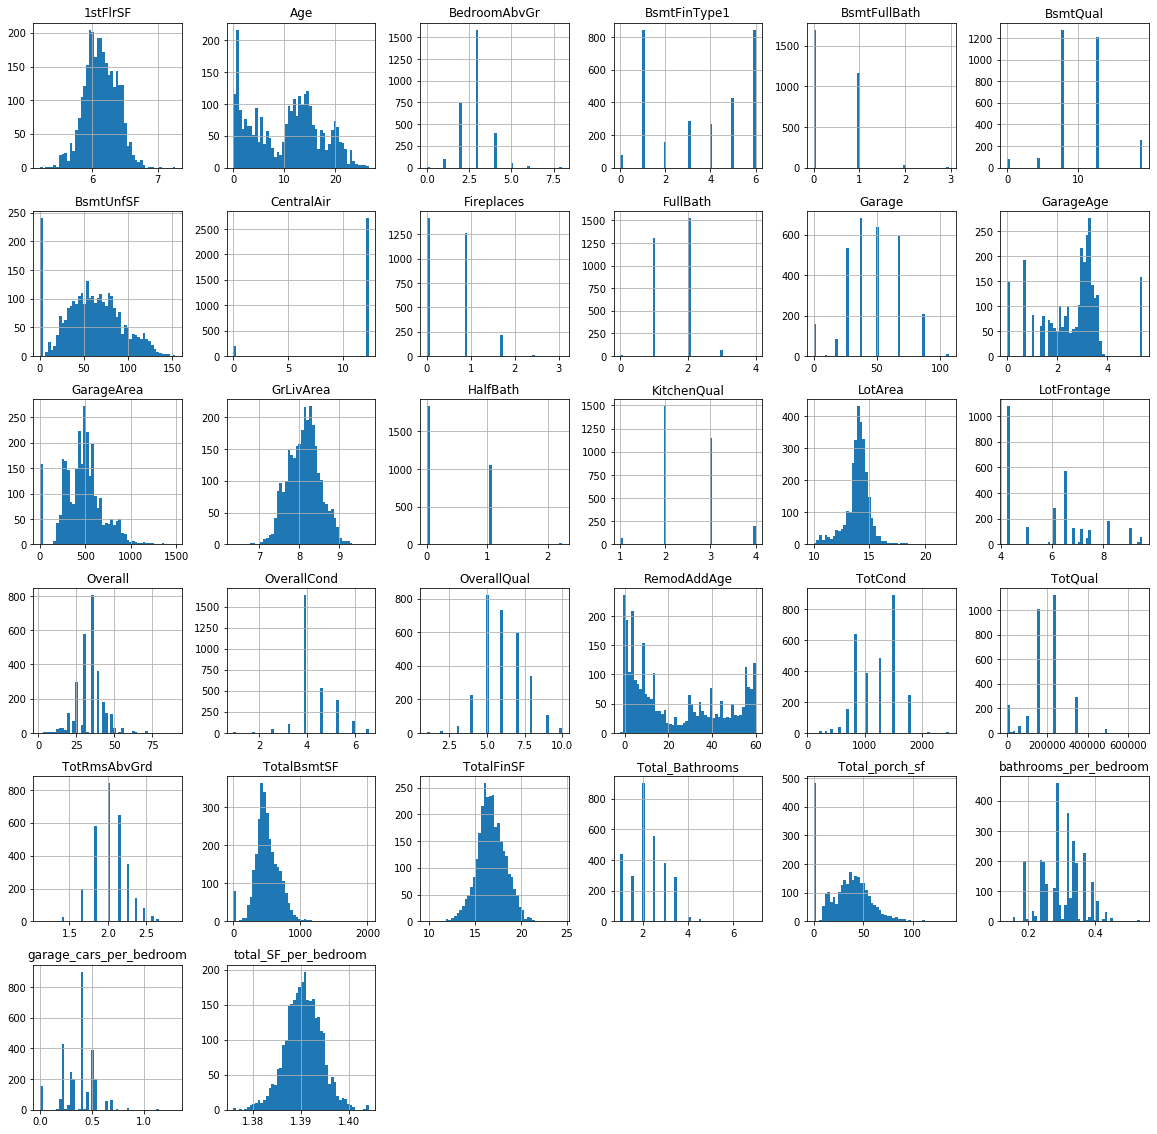

In [15]:
# display histogram for each numerical attribute
import matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt
housing_extra_attribs[numerical_features].hist(bins=50, figsize=(20,20))
plt.show()

In [16]:
skewness = housing_extra_attribs[numerical_features].apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]

print("There are {} skewed numerical features after Box Cox transform".format(skewness.shape[0]))
print("Mean skewnees: {}".format(np.mean(skewness)))
skewness.sort_values(ascending=False)

There are 4 skewed numerical features after Box Cox transform
Mean skewnees: -0.3944633005188434


HalfBath        0.730155
BsmtFullBath    0.614203
Fireplaces      0.553661
CentralAir     -3.475872
dtype: float64

## Numerical and Categorical Features

In [17]:
num_cols =  housing_extra_attribs.select_dtypes(exclude = ["object"]).columns.to_list()
cat_cols = housing_extra_attribs.select_dtypes(include = ["object"]).columns.to_list()
print(num_cols, "\n", cat_cols)

['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'BsmtQual', 'BsmtFinType1', 'BsmtUnfSF', 'TotalBsmtSF', 'CentralAir', '1stFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'GarageArea', 'TotQual', 'TotCond', 'Overall', 'GarageAge', 'Age', 'RemodAddAge', 'total_SF_per_bedroom', 'garage_cars_per_bedroom', 'Total_Bathrooms', 'bathrooms_per_bedroom', 'TotalFinSF', 'Garage', 'Total_porch_sf'] 
 ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'GarageType', 'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']


## Numeric Pipeline

Now let's build a pipeline for preprocessing the numerical attributes (note that we could use CombinedAttributesAdder() instead of FunctionTransformer(...) if we preferred):

In [18]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler

def onehot(X): 
    return pd.get_dummies(X)

def scale_features(X, scaler = RobustScaler()): 
    scaler.fit_transform(X)
    return pd.DataFrame(scaler.fit_transform(X),index = X.index, columns = X.columns)


def hash_encode(X):
    from sklearn.feature_extraction import FeatureHasher
    features = []
    
    fh = FeatureHasher(n_features=2, input_type='string')
    hashed_features = fh.fit_transform(X['Neighborhood'])
    hashed_features = hashed_features.toarray()
    X = pd.concat([X, pd.DataFrame(hashed_features, columns = ['Neigb1', 'Neighb2'])], 
          axis=1).drop(['Neighborhood'], axis = 1)
    
    fh = FeatureHasher(n_features=1, input_type='string')
    hashed_features = fh.fit_transform(X['MoSold'])
    hashed_features = hashed_features.toarray()
    X = pd.concat([X, pd.DataFrame(hashed_features, columns = ['MonthSold'])], 
          axis=1).drop(['MoSold'], axis = 1)
       
    fh = FeatureHasher(n_features=1, input_type='string')
    hashed_features = fh.fit_transform(X['MSSubClass'])
    hashed_features = hashed_features.toarray()
    X = pd.concat([X, pd.DataFrame(hashed_features, columns = ['SubClass'])], 
          axis=1).drop(['MSSubClass'], axis = 1)
    
    fh = FeatureHasher(n_features=1, input_type='string')
    hashed_features = fh.fit_transform(X['Exterior2nd'])
    hashed_features = hashed_features.toarray()
    X = pd.concat([X, pd.DataFrame(hashed_features, columns = ['Exter2nd'])], 
          axis=1).drop(['Exterior2nd'], axis = 1)
    
    fh = FeatureHasher(n_features=1, input_type='string')
    hashed_features = fh.fit_transform(X['Exterior1st'])
    hashed_features = hashed_features.toarray()
    X = pd.concat([X, pd.DataFrame(hashed_features, columns = ['Exter1st'])], 
          axis=1).drop(['Exterior1st'], axis = 1)
    
    fh = FeatureHasher(n_features=1, input_type='string')
    hashed_features = fh.fit_transform(X['Condition1'])
    hashed_features = hashed_features.toarray()
    X = pd.concat([X, pd.DataFrame(hashed_features, columns = ['Cond1'])], 
          axis=1).drop(['Condition1'], axis = 1)
    
    fh = FeatureHasher(n_features=1, input_type='string')
    hashed_features = fh.fit_transform(X['Condition2'])
    hashed_features = hashed_features.toarray()
    X = pd.concat([X, pd.DataFrame(hashed_features, columns = ['Cond2'])], 
          axis=1).drop(['Condition2'], axis = 1)
    
    fh = FeatureHasher(n_features=1, input_type='string')
    hashed_features = fh.fit_transform(X['RoofMatl'])
    hashed_features = hashed_features.toarray()
    X = pd.concat([X, pd.DataFrame(hashed_features, columns = ['RoofMl'])], 
          axis=1).drop(['RoofMatl'], axis = 1)
    
    fh = FeatureHasher(n_features=1, input_type='string')
    hashed_features = fh.fit_transform(X['Heating'])
    hashed_features = hashed_features.toarray()
    X = pd.concat([X, pd.DataFrame(hashed_features, columns = ['Heat'])], 
          axis=1).drop(['Heating'], axis = 1)
    
    fh = FeatureHasher(n_features=1, input_type='string')
    hashed_features = fh.fit_transform(X['MSZoning'])
    hashed_features = hashed_features.toarray()
    X = pd.concat([X, pd.DataFrame(hashed_features, columns = ['MZone'])], 
          axis=1).drop(['MSZoning'], axis = 1)
    
    fh = FeatureHasher(n_features=1, input_type='string')
    hashed_features = fh.fit_transform(X['SaleType'])
    hashed_features = hashed_features.toarray()
    X = pd.concat([X, pd.DataFrame(hashed_features, columns = ['SaleTyp'])], 
          axis=1).drop(['SaleType'], axis = 1)
    
    fh = FeatureHasher(n_features=1, input_type='string')
    hashed_features = fh.fit_transform(X['MiscFeature'])
    hashed_features = hashed_features.toarray()
    X = pd.concat([X, pd.DataFrame(hashed_features, columns = ['Misc'])], 
          axis=1).drop(['MiscFeature'], axis = 1)
    
    
    
    
    return X

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler

num_pipeline = Pipeline([
        ('imputer', DataFrameImputer()),
        ('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        #('hash', FunctionTransformer(hash_encode, validate=False)),
        ('onehot', FunctionTransformer(onehot, validate=False)),
        #('std_scaler', RobustScaler())
        ('scaler', FunctionTransformer(scale_features, validate=False)),
    ])

data_tr = num_pipeline.fit_transform(data_features)

data_tr.shape

(2912, 240)

In [20]:
data_tr.isna().any().any()

False

In [21]:
data_tr.shape

(2912, 240)

In [22]:
import warnings
warnings.filterwarnings('ignore')

## Add outlier Scores and a label

In [23]:
from pyod.models.knn import KNN
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.lof import LOF

from pyod.utils.data import get_outliers_inliers
outliers_fraction = 0.1
random_state = 42
from sklearn.cluster import KMeans

classifiers = {
    'Angle-based Outlier Detector (ABOD)'   : ABOD(contamination=outliers_fraction),
    'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
    'K Nearest Neighbors (KNN)' :  KNN(contamination=outliers_fraction),
    'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state)
}

clf =  KNN(contamination=outliers_fraction)
#clf = CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state)

clf.fit(data_tr)

data_tr["outlier"] = clf.predict(data_tr)

for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(data_tr)
    # predict raw anomaly score
    data_tr[clf_name+' score']=clf.decision_function(data_tr) * -1
    data_tr[clf_name+' score'].replace(-np.inf, np.min(data_tr[clf_name+' score'].replace(-np.inf, np.nan)))
    if clf_name=='Cluster-based Local Outlier Factor (CBLOF)':
        clf.fit(data_tr)
        data_tr["CBLOFlabel"]=clf.cluster_labels_



In [24]:
#dX.drop(['outlier','score'], axis = 1, inplace = True)
#dX_test.drop(['outlier', 'score'], axis = 1, inplace = True)

## Columns with zeros

In [25]:
# Removes colums where the threshold of zero's is (> 99.95), means has only zero values 
overfit = []
for i in data_tr.columns:
    counts = data_tr[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(data_tr) * 100 > 99.96:
        overfit.append(i)

overfit = list(overfit)
#overfit.append('MSZoning_C (all)')


data_tr = data_tr.drop(overfit, axis=1).copy()

overfit


['MSSubClass_150',
 'Condition2_RRAe',
 'Condition2_RRAn',
 'RoofMatl_Membran',
 'RoofMatl_Metal',
 'RoofMatl_Roll',
 'Exterior1st_ImStucc',
 'Exterior1st_Other',
 'Heating_Floor',
 'MiscFeature_TenC',
 'SaleType_Other']

## Training and Validation Sets

In [26]:
## split transformed data back to train and test set

#prepare data for use in algorithms
X = data_tr.iloc[0:len(train.index),:]
X_test =  data_tr.iloc[len(train.index):, :]
#y = housing_labels


In [27]:
X.shape, X_test.shape, y.shape

((1453, 235), (1459, 235), (1453,))

In [28]:
import numpy as np

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=train['OverallQual'])

X_train.shape, X_val.shape

((1162, 235), (291, 235))

## Target Variable

In [29]:
np.isnan(y).any()

False

In [30]:
y = np.log1p(y) 


Skewness: 0.153930


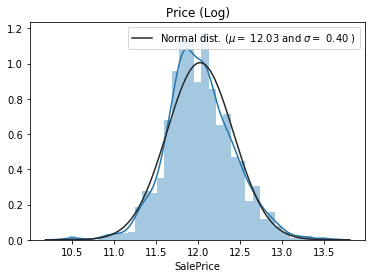

In [31]:
%matplotlib inline 
import seaborn as sns
# target feature transformed
sns.distplot(y , fit=norm);
(mu, sigma) = norm.fit(y)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.title('Price (Log)');
print("Skewness: %f" % pd.DataFrame(y).skew())

In [32]:
y.shape

(1453,)

## Correlations

In [33]:
corr_temp = X[num_cols]
corr_temp['SalePrice'] = y
# Find correlations with the target and sort
correlations = corr_temp.corr(method='spearman')['SalePrice'].sort_values(ascending=False)
correlations_abs = correlations.abs()
print('\nTop 15 correlations (absolute):\n', correlations_abs.head(26))


Top 15 correlations (absolute):
 SalePrice                  1.000000
1stFlrSF                   0.050967
BedroomAbvGr               0.035569
Total_porch_sf             0.035421
TotRmsAbvGrd               0.034168
LotArea                    0.033512
TotalBsmtSF                0.029920
GrLivArea                  0.027604
TotalFinSF                 0.027366
FullBath                   0.027227
Total_Bathrooms            0.026592
Fireplaces                 0.024960
KitchenQual                0.022271
CentralAir                 0.020069
GarageArea                 0.019896
BsmtFullBath               0.016996
BsmtFinType1               0.012034
OverallQual                0.008113
total_SF_per_bedroom       0.006932
TotQual                    0.002975
garage_cars_per_bedroom    0.000729
BsmtUnfSF                  0.000520
bathrooms_per_bedroom      0.000566
TotCond                    0.001952
Age                        0.003740
BsmtQual                   0.004008
Name: SalePrice, dtype: float6

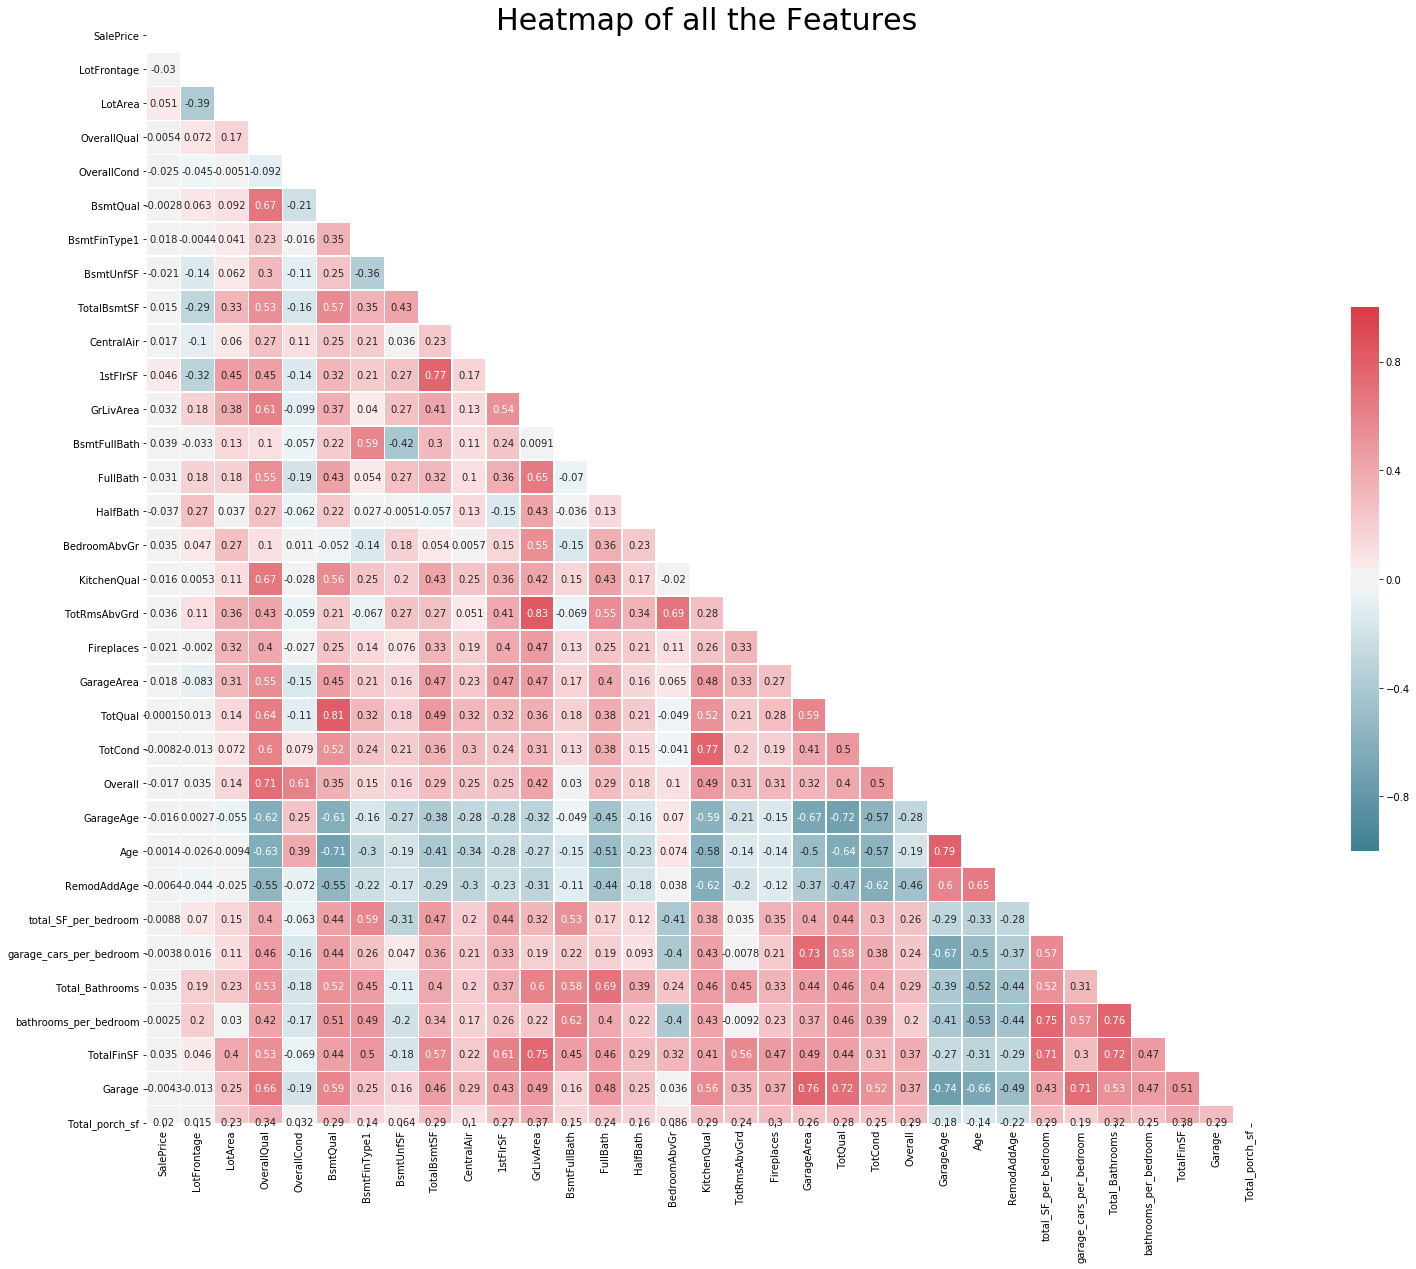

In [34]:
corr_mat=pd.concat([y, X[num_cols]], axis = 1).corr()
mask = np.zeros_like(corr_mat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


## Plot sizing. 
f, ax = plt.subplots(figsize = (30,20))
cmap = sns.diverging_palette(220, 10, as_cmap=True,center="light")
#cmap="BrBG"
## plotting heatmap.  
sns.heatmap(corr_mat, mask=mask, cmap=cmap,annot=True, vmax=1,vmin=-1, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})
## Set the title. 
plt.title("Heatmap of all the Features", fontsize = 30);



## Columns with Identical Values

In [35]:
#find names of duplicate columns
def getDuplicateColumns(df):
    '''
    Get a list of duplicate columns.
    It will iterate over all the columns in dataframe and find the columns whose contents are duplicate.
    :param df: Dataframe object
    :return: List of columns whose contents are duplicates.
    '''
    duplicateColumnNames = set()
    # Iterate over all the columns in dataframe
    for x in range(df.shape[1]):
        # Select column at xth index.
        col = df.iloc[:, x]
        # Iterate over all the columns in DataFrame from (x+1)th index till end
        for y in range(x + 1, df.shape[1]):
            # Select column at yth index.
            otherCol = df.iloc[:, y]
            # Check if two columns at x 7 y index are equal
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])
 
    return list(duplicateColumnNames)

# Get list of duplicate columns
duplicateColumnNames = getDuplicateColumns(X)
 
print('Duplicate Columns are as follows')



for col in duplicateColumnNames:
    print('Column name : ', col)
    
#for dset in [X, X_test, X_train]:
#    dset.drop(duplicateColumnNames, axis =1, inplace = True)

Duplicate Columns are as follows
Column name :  Exterior2nd_CBlock
Column name :  BldgType_Duplex


## Select and Train a Model 

In [36]:
from datetime import datetime
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error , make_scorer
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
from sklearn.linear_model import LinearRegression

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [37]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

# model scoring and validation function
def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y,scoring="neg_mean_squared_error",cv=kfolds, n_jobs = 1))
    return (rmse)

# rmsle scoring function
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [62]:

lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4, #was 3
                                       learning_rate=0.01, 
                                       n_estimators=8000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2, # 'was 0.2'
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                      max_depth=3, min_child_weight=0,
                                      gamma=0, subsample=0.7,
                                      colsample_bytree=0.7,
                                      objective='reg:linear', nthread=-1,
                                      scale_pos_weight=1, seed=27,
                                      reg_alpha=0.00006)



# setup models hyperparameters using a pipline
# The purpose of the pipeline is to assemble several steps that can be cross-validated together, while setting different parameters.
# This is a range of values that the model considers each time in runs a CV
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]


# Kernel Ridge Regression : made robust to outliers
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))

# LASSO Regression : made robust to outliers
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, 
                    alphas=alphas2,random_state=42, cv=kfolds))

# Elastic Net Regression : made robust to outliers
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, 
                         alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))


stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, lightgbm),
                                meta_regressor=elasticnet,
                                use_features_in_secondary=True)

# store models, scores and prediction values 
models = {'Ridge': ridge,
          'Lasso': lasso, 
          'ElasticNet': elasticnet,
          'lightgbm': lightgbm,
          #'xgboost': xgboost,
          'Stack':stack_gen,
         }
    
predictions = {}
scores = {}

In [63]:


for name, model in models.items():
    
    model.fit(X, y)
    predictions[name] = np.expm1(model.predict(X))
    
    score = cv_rmse(model, X=X)
    scores[name] = (score.mean(), score.std())

(pd.DataFrame.from_dict(scores, orient='index', columns = ['RMSE Mean', 'RMSE SD']).reset_index()).sort_values(by=['RMSE Mean'], ascending=True)


,index,RMSE Mean,RMSE SD
1,Lasso,0.102576,0.012383
2,ElasticNet,0.102703,0.012488
0,Ridge,0.103669,0.012770
4,Stack,0.105162,0.013176
3,lightgbm,0.107700,0.014341


In [64]:
# get the performance of each model on training data(validation set)
print('---- Score with CV_RMSLE-----')
score = cv_rmse(ridge)
print("Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(elasticnet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(lightgbm)
print("lightgbm score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(stack_gen)
print("stack_gen score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

# score = cv_rmse(xgboost)
print("xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


#Fit the training data X, y
print('----START Fit----',datetime.now())
print('Elasticnet')
elastic_model = elasticnet.fit(X, y)
print('Lasso')
lasso_model = lasso.fit(X, y)
print('Ridge')
ridge_model = ridge.fit(X, y)
print('Lightgbm')
lgb_model = lightgbm.fit(X, y)
print('stack_gen')
stack_model = stack_gen.fit(X, y)

print('xgboost')
xgb_model_full_data = xgboost.fit(X, y)


---- Score with CV_RMSLE-----
Ridge score: 0.1037 (0.0128)

Lasso score: 0.1026 (0.0124)

ElasticNet score: 0.1027 (0.0125)

lightgbm score: 0.1077 (0.0143)

stack_gen score: 0.1041 (0.0138)

xgboost score: 0.1041 (0.0138)

----START Fit---- 2020-02-10 14:18:08.335893
Elasticnet
Lasso
Ridge
Lightgbm
stack_gen
xgboost
[14:18:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [65]:
def blend_models_predict(X):
    return ((0.25  * elastic_model.predict(X)) + \
            (0.25 * lasso_model.predict(X)) + \
            (0.25 * ridge_model.predict(X)) + \
            (0.25 * lgb_model.predict(np.array(X))) + \
#             (0.1 * xgb_model_full_data.predict(X)) + \
            (0 * stack_gen.predict(np.array(X)))
           )

In [66]:
print('RMSLE score on train data:')
print(rmsle(y, blend_models_predict(X)))

RMSLE score on train data:
0.0820161675433322


## Submission

In [67]:
print('Predict submission')
submission = pd.read_csv("sample_submission.csv")
submission.iloc[:,1] = (np.expm1(blend_models_predict(X_test)))

Predict submission


In [68]:
submission.to_csv("submission.csv", index=False)

## Plot Resifuals

In [84]:
#r = ridge
#r.fit(X_train, y_train)

y_train_pred = blend_models_predict(X_train)
y_val_pred   = blend_models_predict(X_val)

#resid = pd.DataFrame()


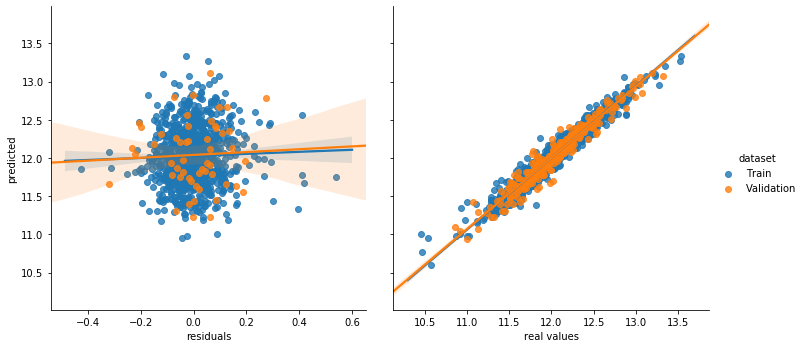

In [85]:

train2 = pd.DataFrame(np.vstack((y_train_pred, y_train)).T, columns = ['predicted', 'real values'])
train2['dataset'] =  'Train'
train2['residuals'] = (y_train_pred - y_train)


train3 = pd.DataFrame(np.vstack((y_val_pred, y_val)).T, columns = ['predicted', 'real values'])
train3['dataset'] =  'Validation'
train3['residuals'] = y_val_pred - y_val

dat = pd.concat([train2, train3], axis =0).reset_index(drop = True)

sns.pairplot(dat, x_vars=["residuals", "real values"], y_vars=["predicted"],
            hue = "dataset", height=5, aspect=1, kind="reg");

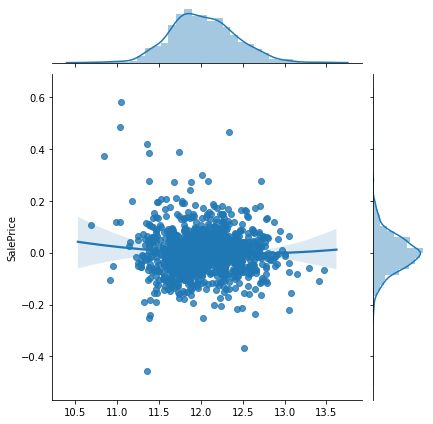

In [96]:
g = sns.JointGrid(x=y_train_pred, y=y_train_pred - y_train) 
g.plot_joint(sns.regplot, order=2) 
g.plot_marginals(sns.distplot)

## Most Important Features

Top 10 features:
                                             Feature  Coefficient
0                                        OverallQual     0.538945
1                                         TotalFinSF     0.242471
2                                         GarageArea     0.023709
3                                            Overall     0.023477
4                                          GrLivArea     0.021697
5                             Isolation Forest score     0.014660
6                                        TotalBsmtSF     0.013928
7                                             Garage     0.010116
8                                            LotArea     0.009691
9                                        RemodAddAge     0.007484
10                                               Age     0.007139
11                                 GarageType_Detchd     0.006166
12                                          1stFlrSF     0.006079
13                                   Total_Bathrooms     0.

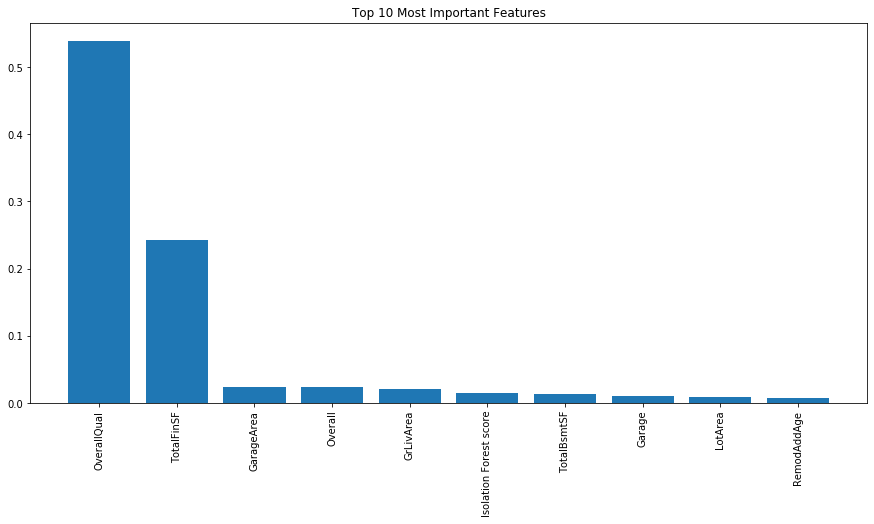

In [86]:
from sklearn.ensemble import RandomForestRegressor
rf_imp = RandomForestRegressor(n_estimators=1200,
                               max_depth=15,
                               min_samples_split=5,
                               min_samples_leaf=5,
                               max_features=None,
                               oob_score=True,
                               random_state=42,
                               n_jobs = -1)
pipe = make_pipeline(RobustScaler())

rf_imp.fit(pipe.fit_transform(X_train), y_train)
importances = rf_imp.feature_importances_
df_param_coeff = pd.DataFrame(columns=['Feature', 'Coefficient'])
for i in range(len(X_train.columns)-1):
    feat = X_train.columns[i]
    coeff = importances[i]
    df_param_coeff.loc[i] = (feat, coeff)
df_param_coeff.sort_values(by='Coefficient', ascending=False, inplace=True)
df_param_coeff = df_param_coeff.reset_index(drop=True)
print("Top 10 features:\n{}".format(df_param_coeff.head(50)))

importances = rf_imp.feature_importances_
indices = np.argsort(importances)[::-1] # Sort feature importances in descending order

names = [X_train.columns[i] for i in indices] # Rearrange feature names so they match the sorted feature importances
plt.figure(figsize=(15, 7)) # Create plot
plt.title("Top 10 Most Important Features") # Create plot title
plt.bar(range(10), importances[indices][:10]) # Add bars
plt.xticks(range(10), names[:10], rotation=90) # Add feature names as x-axis labels
#plt.bar(range(X_train.shape[1]), importances[indices]) # Add bars
#plt.xticks(range(X_train.shape[1]), names, rotation=90) # Add feature names as x-axis labels
plt.show() # Show plot

In [87]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.99)
X_reduced = pca.fit_transform(X)
X_reduced.shape

(1453, 2)

In [89]:
X_train, X_val, y_train, y_val = train_test_split(X_reduced, y, test_size = 0.2, random_state=42, stratify=train['OverallQual'])

X_train.shape, X_val.shape

((1162, 2), (291, 2))

## Cluster Approach

In [90]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from mlxtend.regressor import StackingCVRegressor, StackingRegressor
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import model_selection
from lightgbm import LGBMRegressor
import xgboost as xgb
from sklearn.svm import SVR
from sklearn import neighbors

models = []

# setup models hyperparameters using a pipline
# The purpose of the pipeline is to assemble several steps that can be cross-validated together, while setting different parameters.
# This is a range of values that the model considers each time in runs a CV
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003,
           0.0004, 0.0005, 0.0006, 0.0007, 0.0008]


lightgbm = LGBMRegressor(objective='regression',
                         num_leaves=4,  # was 3
                         learning_rate=0.01,
                         n_estimators=8000,
                         max_bin=200,
                         bagging_fraction=0.75,
                         bagging_freq=5,
                         bagging_seed=7,
                         feature_fraction=0.2,  # 'was 0.2'
                         feature_fraction_seed=7,
                         verbose=-1,
                         )

xgboost = make_pipeline(RobustScaler(), XGBRegressor(learning_rate=0.01, n_estimators=3460,
                                                     max_depth=3, min_child_weight=0,
                                                     gamma=0, subsample=0.7,
                                                     colsample_bytree=0.7,
                                                     objective='reg:linear', nthread=-1,
                                                     scale_pos_weight=1, seed=27,
                                                     reg_alpha=0.00006))


xgb_reg = make_pipeline(RobustScaler(), XGBRegressor(
    objective='reg:squarederror', random_state=42))

# Kernel Ridge Regression : made robust to outliers
ridge = make_pipeline(RobustScaler(), RidgeCV(cv=kfolds))

# LASSO Regression : made robust to outliers
lasso = make_pipeline(RobustScaler(), LassoCV(
    max_iter=1e7, random_state=42, cv=kfolds))

# Elastic Net Regression : made robust to outliers
elasticnet = make_pipeline(
    RobustScaler(), ElasticNetCV(max_iter=1e7, cv=kfolds))
# Gradient Boost
gbr = make_pipeline(RobustScaler(), GradientBoostingRegressor())

# SVR
svr = make_pipeline(RobustScaler(), SVR())

# =======
# SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='scale',
#    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

# Stack Regression :
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, lightgbm),
                                meta_regressor=elasticnet,
                                use_features_in_secondary=True)
# Stack Regression1 :
stack_gen1 = StackingRegressor(regressors=(ridge, svr, xgb_reg, gbr),
                               meta_regressor=svr,
                               use_features_in_secondary=False)


# Random Forest
rf = make_pipeline(RobustScaler(), RandomForestRegressor(
    n_estimators=100, random_state=7, n_jobs=-1))


models.append(('LGBM Regressor', lightgbm))
# Kernel Ridge Regression : made robust to outliers
models.append(('RidgeCV', ridge))
# LASSO Regression : made robust to outliers
models.append(('LassoCV', lasso))
# Elastic Net Regression : made robust to outliers
models.append(('ElasticNetCV', elasticnet))
# XGBoost Linear Regression :
models.append(('XGBoost L', xgboost))
# XGBoost Squared Regression :
models.append(('XGBoost Sq', xgb_reg))
# SVR Regression
models.append(('SVR', svr))
# Gradient Boost
models.append(('Gradient Boosting', gbr))
# Stack Regression :
models.append(('Stack', stack_gen))
# Stack Regression 1 :
models.append(('Stack1', stack_gen1))
# Random Forest
models.append(('Random Forest', rf))


# set table to table to populate with performance results
rmse_results = []
names = []
col = ['Algorithm', 'RMSE Mean', 'RMSE SD']
df_results = pd.DataFrame(columns=col)

# evaluate each model using cross-validation
kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=42)
i = 0


for name, model in models:
    # -mse scoring
    print(name)
    cv_mse_results = model_selection.cross_val_score(
        model, np.array(X), np.array(y), cv=kfold, scoring="neg_mean_squared_error", n_jobs=-1)

    # calculate and append rmse results
    cv_rmse_results = np.sqrt(-cv_mse_results)
    rmse_results.append(cv_rmse_results)
    names.append(name)
    df_results.loc[i] = [name,
                         round(cv_rmse_results.mean(), 4),
                         round(cv_rmse_results.std(), 4)]
    i += 1

df_results.sort_values(by=['RMSE Mean'], ascending=True).reset_index(drop=True)

LGBM Regressor
RidgeCV
LassoCV
ElasticNetCV
XGBoost L
XGBoost Sq
SVR
Gradient Boosting
Stack
Stack1
Random Forest


,Algorithm,RMSE Mean,RMSE SD
0,XGBoost L,0.1055,0.0123
1,LGBM Regressor,0.1081,0.0126
2,RidgeCV,0.1097,0.0118
3,XGBoost Sq,0.1153,0.0133
4,Gradient Boosting,0.1156,0.0115
5,Stack1,0.1246,0.0125
6,Random Forest,0.1284,0.0146
7,SVR,0.1311,0.0113
8,Stack,0.2174,0.0301
9,LassoCV,0.2442,0.0376


In [91]:
def blend_models_predict(X):
    return ((0  * elasticnet.predict(X)) + \
            (0 * lasso.predict(X)) + \
            (0.3333 * ridge.predict(X)) + \
            #(0.15 * stack_gen1.predict(X)) + \
            (0.3333 * xgboost.predict(X)) + \
            (0.3333 * lightgbm.predict(np.array(X))))

In [92]:
# fit models to entire dataset
for name, model in models:
    # -mse scoring
    print(name)
    model.fit(X, y)

LGBM Regressor
RidgeCV
LassoCV
ElasticNetCV
XGBoost L
[00:56:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost Sq
SVR
Gradient Boosting
Stack
Stack1
Random Forest


In [93]:
print('RMSLE score on train data:')
print(rmsle(y, blend_models_predict(X)))

RMSLE score on train data:
0.06469638023017442


In [94]:
print('Predict submission')
submission = pd.read_csv("sample_submission.csv")
submission.iloc[:,1] = (np.expm1(blend_models_predict(X_test)))
submission.to_csv("last.csv", index = False)

Predict submission


## Fine Tune XGBoost

In [42]:
import xgboost as xgb
xgb_regressor = xgb.XGBRegressor(random_state=42)

In [43]:
from time import time
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

start = time() # Get start time
cv_sets_xgb = ShuffleSplit(random_state = 10) # shuffling our data for cross-validation
scorer_xgb = make_scorer(mean_squared_error)

parameters_xgb = {'n_estimators':range(5000, 6000, 5), 
              'learning_rate':[0.01,0.6], 
              'max_depth':[4, 5],
              'min_child_weight':[3,2],
            'objective': ['reg:squarederror', 'reg:tweedie'],
            'reg_alpha': [0, 0.05],
            'gamma': [0.6, 0.3], 
            }

grid_obj_xgb = RandomizedSearchCV(xgb_regressor, 
                                  parameters_xgb,
                                  scoring = scorer, 
                                  cv = cv_sets_xgb,
                                  random_state= 99, n_jobs = -1)
grid_fit_xgb = grid_obj_xgb.fit(dI_train, yI_train)
xgb_opt = grid_fit_xgb.best_estimator_

end = time() # Get end time
xgb_time = (end-start)/60 # Calculate training time
print('It took {0:.2f} minutes for RandomizedSearchCV to converge to optimised parameters for the RandomForest model'.format(xgb_time))
# ## Print results
print('='*20)
print("best params: " + str(grid_fit_xgb.best_estimator_))
print("best params: " + str(grid_fit_xgb.best_params_))
print('best score:', grid_fit_xgb.best_score_)
print('='*20)

KeyboardInterrupt: 

In [68]:
# XGBoost with tuned parameters
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

xgb_opt = xgb.XGBRegressor(learning_rate=0.01,
                           n_estimators=5065,
                           max_depth=4,
                           min_child_weight=3,
                           gamma=0.6,
                           subsample=0.7,
                           colsample_bytree=0.7,
                           objective='reg:squarederror',
                           nthread=-1,
                           scale_pos_weight=1,
                           seed=27,
                           reg_alpha=0.05,
                           random_state=42)

## Gradient Boosting Regressor

In [84]:
gbr = GradientBoostingRegressor()

from time import time
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

start = time() # Get start time
cv_sets_gbr = ShuffleSplit(random_state = 10) # shuffling our data for cross-validation
parameters_gbr = {'n_estimators': [3300], 
              'learning_rate':[0.001,0.01,0.07], 
              'max_depth':[3,5,4],
              'min_samples_leaf':[2,4,3],
                'min_samples_split': [5,6,8], 
                 'loss': ["huber"],
                 'random_state': [42]}
scorer_gbr = make_scorer(mean_squared_error)
grid_obj_gbr = RandomizedSearchCV(gbr, 
                                  parameters_gbr,
                                  scoring = scorer, 
                                  cv = cv_sets_gbr,
                                  random_state= 42, n_jobs = -1)
grid_fit_gbr = grid_obj_gbr.fit(X_train, y_train)
gbr_opt = grid_fit_gbr.best_estimator_

end = time() # Get end time
xgb_time = (end-start)/60 # Calculate training time
print('It took {0:.2f} minutes for RandomizedSearchCV to converge to optimised parameters for the RandomForest model'.format(xgb_time))
# ## Print results
print('='*20)
print("best params: " + str(grid_fit_gbr.best_estimator_))
print("best params: " + str(grid_fit_gbr.best_params_))
print('best score:', grid_fit_gbr.best_score_)
print('='*20)

It took 45.42 minutes for RandomizedSearchCV to converge to optimised parameters for the RandomForest model
best params: GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.001, loss='huber', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=2, min_samples_split=5,
                          min_weight_fraction_leaf=0.0, n_estimators=3300,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
best params: {'random_state': 42, 'n_estimators': 3300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 3, 'loss': 'huber', 'learning_rate': 0.001}
best score: 0.019153823618276923


In [77]:
from sklearn.ensemble import GradientBoostingRegressor
gbr_opt = GradientBoostingRegressor(n_estimators=3300,
                                learning_rate=0.001,
                                max_depth=3,
                                max_features='sqrt',
                                min_samples_leaf=2,
                                min_samples_split=5,
                                loss='huber',
                                random_state=42)

## LGBM Regressor

In [63]:
lightgbm = LGBMRegressor(random_state=42)


from time import time
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

start = time() # Get start time
cv_sets = ShuffleSplit(random_state = 10) # shuffling our data for cross-validation
parameters = {'n_estimators':[3000, 4000, 7000], 
              'learning_rate':[0.001,0.01,0.07], 
              'max_bin':[150,200,250],
              'bagging_fraction': [0.8, 0.5, 0.9],
                'bagging_freq': [5,4,6], 
                 'feature_fraction': [0.2, 0.3, 0.1],
                  'min_sum_hessian_in_leaf': [11, 10, 9, 15],
                 'random_state': [42],
             'objective': ['regression']}
#scorer = make_scorer(mean_squared_error)
grid_obj = RandomizedSearchCV(lightgbm, 
                                  parameters,
                                  scoring = scorer, 
                                  cv = cv_sets,
                                  random_state= 42, n_jobs = -1)
grid_fit = grid_obj.fit(X_train, y_train)
opt = grid_fit.best_estimator_

end = time() # Get end time
xgb_time = (end-start)/60 # Calculate training time
print('It took {0:.2f} minutes for RandomizedSearchCV to converge to optimised parameters for the RandomForest model'.format(xgb_time))
# ## Print results
print('='*20)
print("best params: " + str(grid_fit.best_estimator_))
print("best params: " + str(grid_fit.best_params_))
print('best score:', grid_fit.best_score_)
print('='*20)

It took 4.09 minutes for RandomizedSearchCV to converge to optimised parameters for the RandomForest model
best params: LGBMRegressor(bagging_fraction=0.9, bagging_freq=5, boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0, feature_fraction=0.1,
              importance_type='split', learning_rate=0.001, max_bin=150,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, min_sum_hessian_in_leaf=15, n_estimators=3000,
              n_jobs=-1, num_leaves=31, objective='regression', random_state=42,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)
best params: {'random_state': 42, 'objective': 'regression', 'n_estimators': 3000, 'min_sum_hessian_in_leaf': 15, 'max_bin': 150, 'learning_rate': 0.001, 'feature_fraction': 0.1, 'bagging_freq': 5, 'bagging_fraction': 0.9}
best score: 0.020206267241584402


In [70]:

from lightgbm import LGBMRegressor
lightgbm = LGBMRegressor(objective='regression', 
                         num_leaves=6,
                         learning_rate=0.001, 
                         n_estimators=3000,
                         max_bin=150, 
                         bagging_fraction=0.9,
                         bagging_freq=5, 
                         bagging_seed=8,
                         feature_fraction=0.1,
                         feature_fraction_seed=8,
                         min_sum_hessian_in_leaf = 15,
                         verbose=-1,
                         random_state=42)

## Random Forest Regressor

In [86]:
start = time() # Get start time
rf_regressor = RandomForestRegressor(random_state=42)
cv_sets = ShuffleSplit(random_state = 4) # shuffling our data for cross-validation
parameters = {'n_estimators': range(300, 500, 5), 
               'min_samples_leaf': [8, 4, 5], 
               'max_depth':[3, 5, 15],
              'min_samples_split': [3, 5, 6],
             }
#scorer = make_scorer(mean_squared_error)
n_iter_search = 10
grid_obj = RandomizedSearchCV(rf_regressor, 
                               parameters, 
                               n_iter = n_iter_search, 
                               scoring = scorer, 
                               cv = cv_sets,
                               random_state= 99, n_jobs = -1)
grid_fit = grid_obj.fit(X_train, y_train)
rf_opt = grid_fit.best_estimator_
end = time() # Get end time
rf_time = (end-start)/60 # Calculate training time
print('It took {0:.2f} minutes for RandomizedSearchCV to converge to optimised parameters for the RandomForest model'.format(rf_time))
## Print results
print('='*20)
print("best params: " + str(grid_fit.best_estimator_))
print("best params: " + str(grid_fit.best_params_))
print('best score:', grid_fit.best_score_)
print('='*20)

It took 3.78 minutes for RandomizedSearchCV to converge to optimised parameters for the RandomForest model
best params: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, n_estimators=460,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)
best params: {'n_estimators': 460, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 3}
best score: 0.024235274308895036


In [71]:
from sklearn.ensemble import RandomForestRegressor
# RandomForest with tuned parameters
rf_reg = RandomForestRegressor(n_estimators=100, 
                               random_state=7)
rf_opt = RandomForestRegressor(n_estimators=460,
                               max_depth=3,
                               min_samples_split=5,
                               min_samples_leaf=4,
                               max_features=None,
                               oob_score=True,
                               random_state=42)

Top 10 features:
                     Feature  Coefficient
0                 totalFlrSF     0.562698
1                OverallQual     0.201096
2                   total_SF     0.037418
3                        Age     0.032250
4                RemodAddAge     0.018766
5                KitchenQual     0.012384
6            total_bathrooms     0.011794
7                   BsmtQual     0.008489
8                 GarageArea     0.008318
9                  GrLivArea     0.008092
10                   LotArea     0.007605
11                   score.2     0.006825
12   garage_cars_per_bedroom     0.006369
13                   score.1     0.004531
14                 GarageAge     0.004461
15                GarageCars     0.004416
16     bathrooms_per_bedroom     0.003981
17               OverallCond     0.003898
18               TotalBsmtSF     0.003538
19                BsmtFinSF1     0.003475
20            total_porch_sf     0.003288
21                  1stFlrSF     0.002540
22               

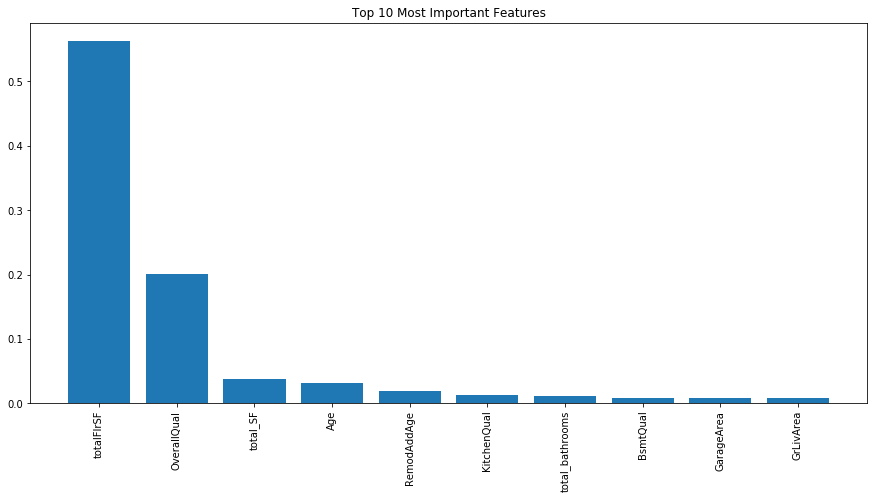

In [50]:
rf_imp = RandomForestRegressor(n_estimators=1200,
                               max_depth=15,
                               min_samples_split=5,
                               min_samples_leaf=5,
                               max_features=None,
                               oob_score=True,
                               random_state=42)
rf_imp.fit(dI_train, yI_train)
importances = rf_imp.feature_importances_
df_param_coeff = pd.DataFrame(columns=['Feature', 'Coefficient'])
for i in range(len(dI_train.columns)-1):
    feat = dI_train.columns[i]
    coeff = importances[i]
    df_param_coeff.loc[i] = (feat, coeff)
df_param_coeff.sort_values(by='Coefficient', ascending=False, inplace=True)
df_param_coeff = df_param_coeff.reset_index(drop=True)
print("Top 10 features:\n{}".format(df_param_coeff.head(211)))

importances = rf_imp.feature_importances_
indices = np.argsort(importances)[::-1] # Sort feature importances in descending order

names = [dI_train.columns[i] for i in indices] # Rearrange feature names so they match the sorted feature importances
plt.figure(figsize=(15, 7)) # Create plot
plt.title("Top 10 Most Important Features") # Create plot title
plt.bar(range(10), importances[indices][:10]) # Add bars
plt.xticks(range(10), names[:10], rotation=90) # Add feature names as x-axis labels
#plt.bar(range(X_train.shape[1]), importances[indices]) # Add bars
#plt.xticks(range(X_train.shape[1]), names, rotation=90) # Add feature names as x-axis labels
plt.show() # Show plot

In [103]:
to_drop = ['AsphShn','AsbShng.001', 'ImStucc', 'WdShing', 'Other', 'Others.002', 'Stone','Stucco.001','AsbShng',
           'Others.001','CompShg','BrkCmn','Shed','Mansard','Flat','PosN','2.5S','2fmCon','Others','Stone.002',
           'Wood','Norm.001','GasW','Others.003','2Types','RRNn','Basment','RRNe','CarPort','RRAn']
to_drop =['Functional_Min1', 'Functional_Mod', 'Neighborhood_Blueste','RoofMatl_Membran','HeatingQC_Po','RoofStyle_Shed']


In [104]:
for dset in [X, X_test]:
    dset.drop(to_drop, axis =1, inplace = True)

## Ridge Regression

In [72]:
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import KFold
kfolds = KFold(n_splits=5, shuffle=True, random_state=7)
rcv_alphas = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5] #[14, 16, 0.1, 0.001, 5 , 4]
ridge = RidgeCV(alphas=rcv_alphas, 
                cv=kfolds)

## SVR

In [73]:
from sklearn.svm import SVR
svr = SVR(C= 20, 
          epsilon= 0.008, 
          gamma=0.0003)

## LassoCV

In [74]:
lassoCV_opt = LassoCV(max_iter=1e7, 
                    alphas=alphas2,random_state=42, cv=kfolds)

## Others

In [89]:

elasticNetCV_opt = ElasticNetCV(max_iter=1e7, 
                         cv=kfolds, l1_ratio=e_l1ratio)
lgbm_opt = LGBMRegressor(objective='regression',
               num_leaves=4, #was 3
               learning_rate=0.007, 
               n_estimators=12000,
               max_bin=200, 
               bagging_fraction=0.75,
               bagging_freq=5, 
               bagging_seed=7,
               feature_fraction=0.2, # 'was 0.2'
               feature_fraction_seed=7,
               verbose=-1)
ridgeCV_opt = RidgeCV(alphas=alphas_alt, cv=kfolds)

In [87]:
e_alphas

[0.0007]

## Model Performance Review

In [92]:
from time import time
from sklearn import model_selection
from mlxtend.regressor import StackingCVRegressor, StackingRegressor

# selection of algorithms to consider
start = time() # Get start time
models = []
models.append(('Ridge Regression', ridge))
models.append(('Random Forest', rf_opt))
models.append(('XGBoost Regressor', xgb_opt))
models.append(('Gradient Boosting Regressor', gbr_opt))
models.append(('LGBM Regressor',lightgbm))
models.append(('SVR',svr))
models.append(('KNN',neighbors.KNeighborsRegressor(n_neighbors = 11)))

models.append(('RidgeCV', ridgeCV_opt))
models.append(('LassoCV', lassoCV_opt))
models.append(('ElasticNetCV', elasticNetCV_opt))
models.append(('LGBM Regressor', lgbm_opt))

models.append(('StackingRegressor',StackingRegressor(regressors=(ridge,svr, xgb_opt, gbr_opt),
                                                     meta_regressor=svr,
                                                     use_features_in_secondary=False)))
models.append(('StackingRegressor1',StackingRegressor(regressors=(lassoCV_opt,elasticNetCV_opt,ridgeCV_opt ),
                                                     meta_regressor=lassoCV_opt,
                                                     use_features_in_secondary=True)))

# set table to table to populate with performance results
rmse_results = []
names = []
col = ['Algorithm', 'RMSE Mean', 'RMSE SD']
df_results = pd.DataFrame(columns=col)

# evaluate each model using cross-validation
kfold = model_selection.KFold(n_splits=5, shuffle = True, random_state=7)
i = 0
for name, model in models:
    print("Evaluating {}...".format(name))
    # -mse scoring
    cv_mse_results = model_selection.cross_val_score(
        model, np.array(dX_train), np.array(y_train), cv=kfold, scoring='neg_mean_squared_error',n_jobs = -1)
    # calculate and append rmse results
    cv_rmse_results = np.sqrt(-cv_mse_results)
    rmse_results.append(cv_rmse_results)
    names.append(name)
    df_results.loc[i] = [name,
                         round(cv_rmse_results.mean(), 4),
                         round(cv_rmse_results.std(), 4)]
    i += 1
end = time() # Get end time
eval_time = (end-start)/60 # Calculate training time
print('Evaluation completed.\nIt took {0:.2f} minutes to evaluate all models using a 5-fold cross-validation.'.format(eval_time))
df_results.sort_values(by=['RMSE Mean'], ascending=True).reset_index(drop=True)



Evaluating Ridge Regression...
Evaluating Random Forest...
Evaluating XGBoost Regressor...
Evaluating Gradient Boosting Regressor...
Evaluating LGBM Regressor...
Evaluating SVR...
Evaluating KNN...
Evaluating RidgeCV...
Evaluating LassoCV...
Evaluating ElasticNetCV...
Evaluating LGBM Regressor...
Evaluating StackingRegressor...
Evaluating StackingRegressor1...
Evaluation completed.
It took 5.84 minutes to evaluate all models using a 5-fold cross-validation.


,Algorithm,RMSE Mean,RMSE SD
0,SVR,0.1124,0.0091
1,StackingRegressor,0.1143,0.0092
2,LGBM Regressor,0.1217,0.0131
3,Ridge Regression,0.1326,0.0243
4,RidgeCV,0.1326,0.0243
5,StackingRegressor1,0.1328,0.0237
6,XGBoost Regressor,0.1401,0.0114
7,LassoCV,0.1442,0.0220
8,Gradient Boosting Regressor,0.1534,0.0145
9,LGBM Regressor,0.1544,0.0144


## Blending ML Algorithms with StackingCVRegressor

In [93]:
#from mlxtend.regressor import StackingCVRegressor, StackingRegressor
stack_gen = StackingCVRegressor(regressors=(gbr_opt,
                                            xgb_opt,
                                            #lightgbm,
                                            #model,
                                            ridge, 
                                            svr),
                                meta_regressor=svr,
                                use_features_in_secondary=False)

In [107]:
stack_gen = StackingRegressor(regressors=(lassoCV_opt,elasticNetCV_opt,ridgeCV_opt ),
                                                     meta_regressor=lassoCV_opt,
                                                     use_features_in_secondary=True)

In [94]:
print('Fitting models to the training data:')
start = time() # Get start time

df_train_ml = dX
target_ml = y
print('xgboost....')
xgb_model_full_data = xgb_opt.fit(df_train_ml, target_ml)
print('GradientBoosting....')
gbr_model_full_data = gbr_opt.fit(df_train_ml, target_ml)
#print('lightgbm....')
#lgb_model_full_data = lightgbm.fit(df_train_ml, target_ml)
print('RandomForest....')
rf_model_full_data = rf_opt.fit(df_train_ml, target_ml)
print('Ridge....')
ridge_model_full_data = ridge.fit(df_train_ml, target_ml)
print('SVR....')
svr_model_full_data = svr.fit(df_train_ml, target_ml)
print('Stacking Regression....')
stack_gen_model = stack_gen.fit(np.array(df_train_ml), np.array(target_ml))



print('LassoCV....')
lassoCVmodel = lassoCV_opt.fit(np.array(df_train_ml), np.array(target_ml))
print('ElasticNetCV....')
elasticNetCVmodel = elasticNetCV_opt.fit(np.array(df_train_ml), np.array(target_ml))
print('LGBM....')
lgbmmodel = lgbm_opt.fit(np.array(df_train_ml), np.array(target_ml))
print('RidgeCV....')
ridgeCVmodel = ridgeCV_opt.fit(np.array(df_train_ml), np.array(target_ml)) 



end = time() # Get end time
fitting_time = (end-start)/60 # Calculate training time
print('Fitting completed.\nIt took {0:.2f} minutes to fit all the models to the training data.'.format(fitting_time))

Fitting models to the training data:
xgboost....
GradientBoosting....
RandomForest....
Ridge....
SVR....
Stacking Regression....
LassoCV....
ElasticNetCV....
LGBM....
RidgeCV....
Fitting completed.
It took 5.92 minutes to fit all the models to the training data.


## Submission 

In [96]:
def blend_models_predict(X):
    return (((1/2) * stack_gen_model.predict(np.array(X))) + \
            ((1/2) * svr_model_full_data.predict(X)) \
            #((1/5) * lassoCVmodel.predict(X)) +\
            #((1/5) * elasticNetCVmodel.predict(X)) +\
            #((1/7) * gbr_model_full_data.predict(X)) + \
            #((1/7) * lgb_model_full_data.predict(X)) + \
            #((1/7) * xgb_model_full_data.predict(X)) + \
            #((1/7) * rf_model_full_data.predict(X)) + \
            #((1/5) * ridgeCVmodel.predict(X)) \
            #((1/4)* knn_model.predict(X))
           )

In [101]:
# Generate predictions from the blend
y_pred_final = (np.expm1(blend_models_predict(dX_test)))
my_submission2 = pd.DataFrame(y_pred_final, index = dX_test.index, columns = ['SalePrice'])
my_submission2.to_csv('submission-070719_v3.csv')

In [111]:
from time import time
from sklearn import model_selection
from mlxtend.regressor import StackingCVRegressor, StackingRegressor

# selection of algorithms to consider
start = time() # Get start time
models = []
models.append(('Ridge Regression', ridge))
models.append(('Random Forest', rf_opt))
models.append(('XGBoost Regressor', xgb_opt))
models.append(('Gradient Boosting Regressor', gbr_opt))
models.append(('LGBM Regressor',lightgbm))
models.append(('SVR',svr))
models.append(('KNN',neighbors.KNeighborsRegressor(n_neighbors = 11)))

models.append(('RidgeCV', ridgeCV_opt))
models.append(('LassoCV', lassoCV_opt))
models.append(('ElasticNetCV', elasticNetCV_opt))
models.append(('LGBM Regressor', lgbm_opt))

models.append(('StackingRegressor',StackingRegressor(regressors=(ridge,svr, xgb_opt, gbr_opt),
                                                     meta_regressor=svr,
                                                     use_features_in_secondary=False)))
models.append(('StackingRegressor1',StackingRegressor(regressors=(lassoCV_opt,elasticNetCV_opt,ridgeCV_opt ),
                                                     meta_regressor=lassoCV_opt,
                                                     use_features_in_secondary=True)))

# set table to table to populate with performance results
rmse_results = []
names = []
col = ['Algorithm', 'RMSE Mean', 'RMSE SD']
df_results = pd.DataFrame(columns=col)

# evaluate each model using cross-validation
kfold = model_selection.KFold(n_splits=5, shuffle = True, random_state=7)
i = 0
for name, model in models:
    print("Evaluating {}...".format(name))
    # -mse scoring
    cv_mse_results = model_selection.cross_val_score(
        model, dO_train, yO_train, cv=kfold, scoring='neg_mean_squared_error')
    # calculate and append rmse results
    cv_rmse_results = np.sqrt(-cv_mse_results)
    rmse_results.append(cv_rmse_results)
    names.append(name)
    df_results.loc[i] = [name,
                         round(cv_rmse_results.mean(), 4),
                         round(cv_rmse_results.std(), 4)]
    i += 1
end = time() # Get end time
eval_time = (end-start)/60 # Calculate training time
print('Evaluation completed.\nIt took {0:.2f} minutes to evaluate all models using a 5-fold cross-validation.'.format(eval_time))
df_results.sort_values(by=['RMSE Mean'], ascending=True).reset_index(drop=True)



Evaluating Ridge Regression...
Evaluating Random Forest...
Evaluating XGBoost Regressor...
Evaluating Gradient Boosting Regressor...
Evaluating LGBM Regressor...
Evaluating SVR...
Evaluating KNN...
Evaluating RidgeCV...
Evaluating LassoCV...
Evaluating ElasticNetCV...
Evaluating LGBM Regressor...
Evaluating StackingRegressor...
Evaluating StackingRegressor1...
Evaluation completed.
It took 5.69 minutes to evaluate all models using a 5-fold cross-validation.


,Algorithm,RMSE Mean,RMSE SD
0,StackingRegressor,0.2195,0.0396
1,SVR,0.2233,0.0825
2,Ridge Regression,0.2405,0.1063
3,RidgeCV,0.2409,0.1066
4,Gradient Boosting Regressor,0.2415,0.0227
5,Random Forest,0.2427,0.0200
6,XGBoost Regressor,0.2447,0.0227
7,LGBM Regressor,0.2517,0.0256
8,KNN,0.2531,0.0297
9,LGBM Regressor,0.2750,0.0312


In [114]:
print('Fitting models to the training data:')
start = time() # Get start time

df_train_ml = dO
target_ml = yO
print('xgboost....')
xgb_model_full_data = xgb_opt.fit(df_train_ml, target_ml)
print('GradientBoosting....')
gbr_model_full_data = gbr_opt.fit(df_train_ml, target_ml)
#print('lightgbm....')
#lgb_model_full_data = lightgbm.fit(df_train_ml, target_ml)
print('RandomForest....')
rf_model_full_data = rf_opt.fit(df_train_ml, target_ml)
print('Ridge....')
ridge_model_full_data = ridge.fit(df_train_ml, target_ml)
print('SVR....')
svr_model_full_data = svr.fit(df_train_ml, target_ml)
print('Stacking Regression....')
stack_gen_model = stack_gen.fit(np.array(df_train_ml), np.array(target_ml))





end = time() # Get end time
fitting_time = (end-start)/60 # Calculate training time
print('Fitting completed.\nIt took {0:.2f} minutes to fit all the models to the training data.'.format(fitting_time))

Fitting models to the training data:
xgboost....
GradientBoosting....
RandomForest....
Ridge....
SVR....
Stacking Regression....
Fitting completed.
It took 1.67 minutes to fit all the models to the training data.


In [115]:

# Generate predictions from the blend
#svr_model_full_data = svr.fit(dO, yO)



y_pred_final2 = np.expm1(stack_gen_model.predict(dO_test)) 
my_submission2 = pd.DataFrame({'Id': dO_test.index, 'SalePrice': y_pred_final2})

In [116]:
my_submission = pd.concat([my_submission2,my_submission1])

In [117]:
X.shape

(1460, 208)

In [98]:
# Generate submission dataframe
#my_submission = pd.DataFrame({'Id': housing_test.index, 'SalePrice': y_pred_final})

# Exporting submission to CSV
my_submission2.to_csv('submission-070719_v3.csv', index=False)

NameError: name 'my_submission2' is not defined

### Prepare Polynomial Features

In [103]:
from sklearn.preprocessing import PolynomialFeatures

def add_extra_features_2(X, poly=False):
    xx=X.copy()
    if poly:
        poly_features = PolynomialFeatures(degree=2, include_bias = False)
        xx = poly_features.fit_transform(xx.values)
    else:
        xx = pd.concat((xx, (xx**2)), axis = 1)
    
    return xx



# squared numeric features  
X_2 = add_extra_features_2(X, poly=False)


# polynomial numeric features

X_poly = add_extra_features_2(X, poly=True)

In [31]:
X.shape

(1460, 199)

In [32]:
X_test_2.shape

(1459, 253)

In [33]:
X_train_poly.shape

(1168, 1199)

## Select and Train a Model

### Training and Evaluating on the Validation Set

In [194]:
from sklearn.linear_model import Ridge
import sklearn
ridge_reg = Ridge(alpha = 0.001, solver = "cholesky",random_state=42)
ridge_reg.fit(dO_train, yO_train )

from sklearn.metrics import *
# evaluate on validation set
housing_predictions = ridge_reg.predict(dO_val)
lin_mse = sklearn.metrics.mean_squared_error(yO_val, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.2915588941369616

In [117]:
X_test.shape

(1459, 79)

In [178]:
from sklearn.tree import DecisionTreeRegressor
# try a decision tree
tree_reg = DecisionTreeRegressor()#(random_state=42,max_depth=14, min_samples_leaf=4, max_features=22)
tree_reg.fit(dX_train.values, y_train)
# evaluate on validation set
housing_predictions = tree_reg.predict(dX_val)
tree_mse = mean_squared_error(y_val, housing_predictions)
#tree_rmse = np.sqrt(tree_mse)
tree_mse

<tf.Tensor 'Mean_4:0' shape=() dtype=float64>

## Better Evaluation Using Cross-Validation

In [123]:

from sklearn.svm import SVR

svm_reg = SVR(kernel="sigmoid", gamma='scale')
#svm_reg.fit(X_train, y_train)

display_cv_scores(svm_reg, X, y)

Scores: [3.15130024 2.46709482 4.11152342 4.15386464 4.35795115]
Mean: 3.6483468541794024
Standard deviation: 0.723329898309561


In [79]:
scaler = StandardScaler()

In [83]:
import keras
dir(keras.losses)

['K',
 'KLD',
 'MAE',
 'MAPE',
 'MSE',
 'MSLE',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'absolute_import',
 'binary_crossentropy',
 'categorical_crossentropy',
 'categorical_hinge',
 'cosine',
 'cosine_proximity',
 'deserialize',
 'deserialize_keras_object',
 'division',
 'get',
 'hinge',
 'kld',
 'kullback_leibler_divergence',
 'logcosh',
 'mae',
 'mape',
 'mean_absolute_error',
 'mean_absolute_percentage_error',
 'mean_squared_error',
 'mean_squared_logarithmic_error',
 'mse',
 'msle',
 'poisson',
 'print_function',
 'serialize',
 'serialize_keras_object',
 'six',
 'sparse_categorical_crossentropy',
 'squared_hinge']

In [36]:

from keras import backend as K
from keras.losses import *
import math

# root mean squared error (rmse) for regression (only for Keras tensors)
def rmse(y_true, y_pred):
    from keras import backend
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# coefficient of determination (R^2) for regression  (only for Keras tensors)
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return abs( 1 - SS_res/(SS_tot + K.epsilon()) )


from keras.losses import logcosh

from keras import regularizers
from keras.layers.core import Dropout
from keras.models import Sequential
from keras.layers import Activation, Dense

def create_model(epochs=100, batch_size=32, dropout_rate=0.005, l=0.0001, lr=0.001, loss=mean_squared_error ):
    NN_model = Sequential()
    # The Input Layer :
    NN_model.add(Dense(6, kernel_initializer='normal',input_dim = X.shape[1], activation='relu'))
    # The Hidden Layers :
    #NN_model.add(Dense(1, kernel_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(l)))
    #NN_model.add(Dense(1, kernel_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(l)))
    #NN_model.add(Dropout(rate =dropout_rate))
    #NN_model.add(Dense(16, kernel_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(l)))
    NN_model.add(Dense(4, kernel_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(l)))
    # The Output Layer :
    NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

    from keras import optimizers
    adam = optimizers.Adam(lr=lr)
    
    # Compile the network :
    NN_model.compile(loss=loss, optimizer=adam, metrics=['mse'])

    #NN_model.summary()

    return NN_model

NN_model = create_model()
NN_model.summary()

from keras.wrappers.scikit_learn import KerasRegressor
model = KerasRegressor(build_fn=create_model)


Using plaidml.keras.backend backend.
INFO:plaidml:Opening device "metal_amd_radeon_pro_wx_9100.0"
2020-02-11 18:45:05,795 [INFO]  Opening device "metal_amd_radeon_pro_wx_9100.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6)                 1416      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 28        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 1,449
Trainable params: 1,449
Non-trainable params: 0
_________________________________________________________________


In [71]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_name = "Weights-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint_name = "weights.best.hdf5"

checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')

callbacks_list = [EarlyStopping(monitor='val_loss', patience=10),checkpoint]

In [72]:
scaler = StandardScaler()

In [73]:
NN_model.fit(X, y, validation_split=0.33, epochs=200, batch_size=52,verbose = 1, callbacks=callbacks_list)


Train on 973 samples, validate on 480 samples
Epoch 1/200
973/973 [==============================] - 1s 933us/step - loss: 144.6228 - mean_squared_error: 144.6228 - val_loss: 143.8177 - val_mean_squared_error: 143.8177

Epoch 00001: val_loss improved from inf to 143.81768, saving model to weights.best.hdf5
Epoch 2/200
973/973 [==============================] - 0s 93us/step - loss: 143.5788 - mean_squared_error: 143.5788 - val_loss: 142.2614 - val_mean_squared_error: 142.2614

Epoch 00002: val_loss improved from 143.81768 to 142.26138, saving model to weights.best.hdf5
Epoch 3/200
973/973 [==============================] - 0s 92us/step - loss: 141.1305 - mean_squared_error: 141.1305 - val_loss: 138.5542 - val_mean_squared_error: 138.5542

Epoch 00003: val_loss improved from 142.26138 to 138.55421, saving model to weights.best.hdf5
Epoch 4/200
973/973 [==============================] - 0s 93us/step - loss: 135.5587 - mean_squared_error: 135.5587 - val_loss: 130.5467 - val_mean_squared_er


Epoch 00032: val_loss improved from 1.17610 to 1.15325, saving model to weights.best.hdf5
Epoch 33/200
973/973 [==============================] - 0s 95us/step - loss: 1.1850 - mean_squared_error: 1.1848 - val_loss: 1.1247 - val_mean_squared_error: 1.1246

Epoch 00033: val_loss improved from 1.15325 to 1.12474, saving model to weights.best.hdf5
Epoch 34/200
973/973 [==============================] - 0s 94us/step - loss: 1.1586 - mean_squared_error: 1.1584 - val_loss: 1.1077 - val_mean_squared_error: 1.1076

Epoch 00034: val_loss improved from 1.12474 to 1.10775, saving model to weights.best.hdf5
Epoch 35/200
973/973 [==============================] - 0s 99us/step - loss: 1.1347 - mean_squared_error: 1.1346 - val_loss: 1.0839 - val_mean_squared_error: 1.0837

Epoch 00035: val_loss improved from 1.10775 to 1.08385, saving model to weights.best.hdf5
Epoch 36/200
973/973 [==============================] - 0s 101us/step - loss: 1.1080 - mean_squared_error: 1.1079 - val_loss: 1.0547 - val_me


Epoch 00064: val_loss improved from 0.64736 to 0.63556, saving model to weights.best.hdf5
Epoch 65/200
973/973 [==============================] - 0s 96us/step - loss: 0.6314 - mean_squared_error: 0.6313 - val_loss: 0.6250 - val_mean_squared_error: 0.6249

Epoch 00065: val_loss improved from 0.63556 to 0.62501, saving model to weights.best.hdf5
Epoch 66/200
973/973 [==============================] - 0s 92us/step - loss: 0.6203 - mean_squared_error: 0.6202 - val_loss: 0.6160 - val_mean_squared_error: 0.6158

Epoch 00066: val_loss improved from 0.62501 to 0.61597, saving model to weights.best.hdf5
Epoch 67/200
973/973 [==============================] - 0s 93us/step - loss: 0.6098 - mean_squared_error: 0.6096 - val_loss: 0.6089 - val_mean_squared_error: 0.6087

Epoch 00067: val_loss improved from 0.61597 to 0.60886, saving model to weights.best.hdf5
Epoch 68/200
973/973 [==============================] - 0s 93us/step - loss: 0.5999 - mean_squared_error: 0.5998 - val_loss: 0.5954 - val_mea

973/973 [==============================] - 0s 93us/step - loss: 0.3840 - mean_squared_error: 0.3839 - val_loss: 0.3893 - val_mean_squared_error: 0.3892

Epoch 00097: val_loss improved from 0.39407 to 0.38931, saving model to weights.best.hdf5
Epoch 98/200
973/973 [==============================] - 0s 93us/step - loss: 0.3755 - mean_squared_error: 0.3754 - val_loss: 0.3855 - val_mean_squared_error: 0.3854

Epoch 00098: val_loss improved from 0.38931 to 0.38553, saving model to weights.best.hdf5
Epoch 99/200
973/973 [==============================] - 0s 92us/step - loss: 0.3699 - mean_squared_error: 0.3698 - val_loss: 0.3768 - val_mean_squared_error: 0.3767

Epoch 00099: val_loss improved from 0.38553 to 0.37682, saving model to weights.best.hdf5
Epoch 100/200
973/973 [==============================] - 0s 93us/step - loss: 0.3654 - mean_squared_error: 0.3653 - val_loss: 0.3748 - val_mean_squared_error: 0.3747

Epoch 00100: val_loss improved from 0.37682 to 0.37480, saving model to weight

973/973 [==============================] - 0s 93us/step - loss: 0.2517 - mean_squared_error: 0.2516 - val_loss: 0.2713 - val_mean_squared_error: 0.2711

Epoch 00129: val_loss improved from 0.27516 to 0.27129, saving model to weights.best.hdf5
Epoch 130/200
973/973 [==============================] - 0s 97us/step - loss: 0.2489 - mean_squared_error: 0.2487 - val_loss: 0.2684 - val_mean_squared_error: 0.2682

Epoch 00130: val_loss improved from 0.27129 to 0.26837, saving model to weights.best.hdf5
Epoch 131/200
973/973 [==============================] - 0s 98us/step - loss: 0.2455 - mean_squared_error: 0.2453 - val_loss: 0.2657 - val_mean_squared_error: 0.2655

Epoch 00131: val_loss improved from 0.26837 to 0.26569, saving model to weights.best.hdf5
Epoch 132/200
973/973 [==============================] - 0s 95us/step - loss: 0.2428 - mean_squared_error: 0.2426 - val_loss: 0.2641 - val_mean_squared_error: 0.2639

Epoch 00132: val_loss improved from 0.26569 to 0.26407, saving model to weig

973/973 [==============================] - 0s 93us/step - loss: 0.1787 - mean_squared_error: 0.1786 - val_loss: 0.2097 - val_mean_squared_error: 0.2096

Epoch 00161: val_loss improved from 0.21217 to 0.20975, saving model to weights.best.hdf5
Epoch 162/200
973/973 [==============================] - 0s 91us/step - loss: 0.1766 - mean_squared_error: 0.1765 - val_loss: 0.2120 - val_mean_squared_error: 0.2118

Epoch 00162: val_loss did not improve from 0.20975
Epoch 163/200
973/973 [==============================] - 0s 94us/step - loss: 0.1774 - mean_squared_error: 0.1772 - val_loss: 0.2062 - val_mean_squared_error: 0.2061

Epoch 00163: val_loss improved from 0.20975 to 0.20623, saving model to weights.best.hdf5
Epoch 164/200
973/973 [==============================] - 0s 95us/step - loss: 0.1729 - mean_squared_error: 0.1728 - val_loss: 0.2050 - val_mean_squared_error: 0.2048

Epoch 00164: val_loss improved from 0.20623 to 0.20498, saving model to weights.best.hdf5
Epoch 165/200
973/973 [==


Epoch 00193: val_loss improved from 0.17316 to 0.17058, saving model to weights.best.hdf5
Epoch 194/200
973/973 [==============================] - 0s 104us/step - loss: 0.1309 - mean_squared_error: 0.1308 - val_loss: 0.1681 - val_mean_squared_error: 0.1679

Epoch 00194: val_loss improved from 0.17058 to 0.16808, saving model to weights.best.hdf5
Epoch 195/200
973/973 [==============================] - 0s 98us/step - loss: 0.1280 - mean_squared_error: 0.1279 - val_loss: 0.1684 - val_mean_squared_error: 0.1682

Epoch 00195: val_loss did not improve from 0.16808
Epoch 196/200
973/973 [==============================] - 0s 98us/step - loss: 0.1276 - mean_squared_error: 0.1275 - val_loss: 0.1679 - val_mean_squared_error: 0.1677

Epoch 00196: val_loss improved from 0.16808 to 0.16790, saving model to weights.best.hdf5
Epoch 197/200
973/973 [==============================] - 0s 91us/step - loss: 0.1264 - mean_squared_error: 0.1262 - val_loss: 0.1666 - val_mean_squared_error: 0.1665

Epoch 001

In [48]:

#NN_model.load_weights("weights.best.hdf5")
#NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])



housing_predictions = np.expm1((NN_model.predict(X_test)))
submission = pd.DataFrame(data=housing_predictions, index=test_ID , columns = ["SalePrice"])
submission.to_csv("newsixteenth.csv")

In [76]:
X.isnull().any().any()

False

In [120]:

# Generate predictions from the blend
y_pred_final1 = (np.expm1(NN_model.predict(dI_test)))
my_submission1 = pd.DataFrame({'Id': dI_test.index, 'SalePrice': y_pred_final1.ravel()})

In [125]:

# Generate predictions from the blend
y_pred_final2 = (np.expm1(NN_model.predict(dO_test)))
my_submission2 = pd.DataFrame({'Id': dO_test.index, 'SalePrice': y_pred_final2.ravel()})

In [126]:
submission = pd.concat([my_submission1, my_submission2])
submission.to_csv("sixteenth.csv")

## Fine-Tune Your Model

### Grid Search

In [102]:
import scipy
scipy.test()

================================== test session starts ===================================
platform darwin -- Python 3.7.4, pytest-5.2.1, py-1.8.0, pluggy-0.13.0
rootdir: /Users/val/Documents/code/kaggle/housing
plugins: arraydiff-0.3, remotedata-0.3.2, doctestplus-0.4.0, openfiles-0.4.0
collected 26406 items / 10731 deselected / 15675 selected

_build_utils/tests/test_circular_imports.py .                                      [  0%]
_build_utils/tests/test_scipy_version.py .                                         [  0%]
_lib/tests/test__gcutils.py ......                                                 [  0%]
_lib/tests/test__testutils.py ..                                                   [  0%]
_lib/tests/test__threadsafety.py ..                                                [  0%]
_lib/tests/test__util.py ...

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! KeyboardInterrupt !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
/Users/val/opt/anaconda3/envs/beam/lib/python3.7/threading.py:296: KeyboardInterr

False

In [34]:
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import Activation, Dense
from keras.models import Sequential
from keras.layers.core import Dropout
from keras import regularizers
from keras.losses import logcosh
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from keras.losses import *
from keras import backend as K
from keras.losses import *
import math

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

from joblib import Parallel, delayed, parallel_backend

with parallel_backend('threading'):
    param_grid = [
        # try 12 (3×4) combinations of hyperparameters
        #{'n_estimators': [30, 180, 220], 'max_features': [16, 32, 64, 128]},
        # then try 6 (2×3) combinations with bootstrap set as False
        {'epochs': [100, 50, 200], 'batch_size': [64, 32, 128], 'dropout_rate': [0.005, 0.01], 'l': [0.01, 0.0001, 0.05], 'lr': [0.001, 0.01, 0.003], 
        'loss': [hinge, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error]},
        ]

    #forest_reg = RandomForestRegressor(random_state=42)
    # train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
    grid_search = GridSearchCV(model, param_grid, cv=3,
                                   scoring='neg_root_mean_squared_error', return_train_score=True, n_jobs = -1)

    grid_search.fit(X, y)


Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100Epoch 1/100
Epoch 1/100

Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
968/968 [==============================] - 1s 554us/step - loss: 0.4416 - mean_squared_error: 143.3227
Epoch 2/100
Epoch 2/100
Epoch 2/100
968/968 [==============================] - 0s 162us/step - loss: 0.3886 - mean_squared_error: 143.3644
Epoch 3/100
Epoch 3/100
968/968 [==============================] - 0s 171us/step - loss: 0.0010 - mean_squared_error: 139.4414
Epoch 3/100
968/968 [==============================] - 0s 176us/step - loss: 0.0027 - mean_squared_error: 118.5619
Epoch 4/100
Epoch 4/100
Epoch 4/100
968/968 [==============================] - 0s 245us/step - loss: 0.0011 - mean_squared_error: 137.2475
Epoch 5/100
Epoch 5/100
Epoch 5/100
969/969 [==============================] - 1s 1ms/step - loss: 0.6401 - mean_squared_error: 144.2207
Epoch 2/100
969/969 [==============================] - 1s 1ms/step - loss: 0.8885 - mean_squared

Epoch 4/100
Epoch 5/100
968/968 [==============================] - 0s 464us/step - loss: 142.2267 - mean_squared_error: 142.2262968 [>.............................] - ETA: 0s - loss: 9.8296e-04 - mean_squared_error: 
Epoch 4/100
969/969 [==============================] - 0s 465us/step - loss: 0.0019 - mean_squared_error: 119.60239 [============>.................] - ETA: 0s - loss: 142.6968 - mean - ETA: 0s - loss: 9.7849e
Epoch 6/100
969/969 [==============================] - 0s 438us/step - loss: 0.0012 - mean_squared_error: 127.4383
Epoch 6/100
 64/969 [>.............................] - ETA: 0s - loss: 0.0354 - mean_squared_error: 144.8654Epoch 6/100
Epoch 10/100
969/969 [==============================] - 0s 481us/step - loss: 0.0011 - mean_squared_error: 128.0336
Epoch 7/100
969/969 [==============================] - 0s 461us/step - loss: 0.0080 - mean_squared_error: 142.8088
Epoch 6/1
969/969 [==============================] - 0s 510us/step - loss: 5.5889e-04 - mean_squared_error: 

Epoch 8/100960/969 [============================>.] - ETA: 0s - loss: 5.8622e-04 - mean_squared_error: 140.3752
969/969 [==============================] - 0s 460us/step - loss: 0.0011 - mean_squared_error: 138.3897
Epoch 9/1
969/969 [==============================] - 0s 453us/step - loss: 9.9320e-04 - mean_squared_error: 125.95550s - los
Epoch 10/100
969/969 [==============================] - 1s 522us/step - loss: 8.9377e-05 - mean_squared_error: 142.6224
 - 1s 529us/step - loss: 0.0011 - mean_squared_error: 138.4373
Epoch 10/100
Epoch 10/100=========================>.] - ETA: 0s - loss: 6.4280e-04 - mean_squared_error: 130.2077
969/969 [==============================] - 0s 491us/step - loss: 5.0819e-04 - mean_squared_error: 141.5083
Epoch 10/100
968/968 [==============================] - 0s 503us/step - loss: 72.0136 - mean_squared_error: 72.0088
Epoch 9/100
968/968 [==============================] - 0s 488us/step - loss: 8.2383e-04 - mean_squared_error: 137.7185
Epoch 14/100
969/969 

969/969 [==============================] - 0s 491us/step - loss: 4.9654e-04 - mean_squared_error: 141.5130
Epoch 15/100
969/969 [==============================] - 0s 459us/step - loss: 7.2112e-04 - mean_squared_error: 128.4201
Epoch 11/100Epoch 12/100

969/969 [==============================] - 0s 462us/step - loss: 7.1452e-05 - mean_squared_error: 142.6209
Epoch 12/100
832/969 [========================>.....] - 0s 491us/step - loss: 6.1925e-04 - mean_squared_error: 130.8911
 - ETA: 0s - loss: 5.4585e-04 - mean_squared_error: 140.4911Epoch 12/100
969/969 [==============================] - 0s 459us/step - loss: 4.8633e-04 - mean_squared_error: 141.5178
Epoch 12/100
968/968 [==============================] - 0s 471us/step - loss: 7.5406e-04 - mean_squared_error: 137.87878 [>.............................] - ETA: 0s - loss: 3.7793e-04 - mean_squared_error: 142.
Epoch 16/100
969/969 [==============================] - 0s 438us/step - loss: 5.6170e-04 - mean_squared_error: 131.3643
Epoch 13/1

969/969 [==============================] - 0s 455us/step - loss: 25.3932 - mean_squared_error: 25.3862
Epoch 15/100
968/968 [==============================] - 0s 443us/step - loss: 2.6809 - mean_squared_error: 2.6699969 [====>.........................] - ETA: 0s - loss: 4.3821e-04 - mean_squared_err
Epoch 14/100
968/968 [==============================] - 0s 494us/step - loss: 3.6656e-04 - mean_squared_error: 141.2603
Epoch 19/100
968/968 [==============================] - 0s 480us/step - loss: 2.5125e-04 - mean_squared_error: 134.5085
Epoch 20/100
969/969 [==============================] - 0s 493us/step - loss: 8.4419e-04 - mean_squared_error: 138.7616
Epoch 16/100
Epoch 16/100
Epoch 16/100
192/968 [====>.........................] - ETA: 0s - loss: 2.3460 - mean_squared_error: 2.33499.40Epoch 16/100Epoch 20/100

968/968 [==============================] - 0s 485us/step - loss: 6.2418e-04 - mean_squared_error: 138.2083
Epoch 20/100
968/968 [==============================] - 0s 485us/step

Epoch 18/100
Epoch 22/100
Epoch 18/100
968/968 [==============================] - 1s 540us/step - loss: 2.1147 - mean_squared_error: 2.103668 [====>.........................] - ETA: 0s - loss: 1.6134e-04 - mean_squared_error: 
Epoch 17/100
969/969 [==============================] - 1s 529us/step - loss: 4.3767e-04 - mean_squared_error: 141.5524
Epoch 18/100192/968 [====>.........................] - ETA: 0s - loss: 2.0171 - mean_squared_error: 2.0060
969/969 [==============================] - 0s 474us/step - loss: 2.1928 - mean_squared_error: 2.1820
Epoch 18/100
969/969 [==============================] - 0s 506us/step - loss: 2.3668e-04 - mean_squared_error: 134.0941
Epoch 19/100
576/969 [================>.............] - ETA: 0s - loss: 4.3187e-04 - mean_squared_error: 141.0654
Epoch 23/100
 64/969 [>.............................] - ETA: 0s - loss: 7.3329e-04 - mean_squared_error: 138.2983

In [ ]:
grid_search.best_params_ 

In [175]:

housing_predictions = np.expm1((grid_search.best_estimator_.predict(X_test)))
submission = pd.DataFrame(data=housing_predictions, index=housing_test.index , columns = ["SalePrice"])
submission.to_csv("sixteenth.csv")

### Embedings

In [335]:
dfX_train.shape

(1168, 65)

In [336]:
dfX_val.shape

(292, 65)

In [363]:

import seaborn as sns

df_num = num_pipeline.set_params(imputer__cor_cols_to_drop = correlated_columsns_to_drop).fit_transform(housing[num_attribs])
df_cat = DataFrameImputer().fit_transform(housing[cat_attribs])
dfX_train = pd.concat([df_num, df_cat], axis=1, sort=False)

df_num = num_pipeline.set_params(imputer__cor_cols_to_drop = correlated_columsns_to_drop).fit_transform(strat_test_set.drop("SalePrice", axis=1)[num_attribs])
df_cat = DataFrameImputer().fit_transform(strat_test_set.drop("SalePrice", axis=1)[cat_attribs])
dfX_val = pd.concat([df_num, df_cat], axis=1, sort=False)

df_num = num_pipeline.set_params(imputer__cor_cols_to_drop = correlated_columsns_to_drop).fit_transform(housing_test[num_attribs])
df_cat = DataFrameImputer().fit_transform(housing_test[cat_attribs])
dfX_test = pd.concat([df_num, df_cat], axis=1, sort=False)

dfX = pd.concat([dfX_train, dfX_val], axis =0)

In [364]:
dfX.shape

(1460, 55)

In [362]:
data_df = dfX
embed_cols=[i for i in data_df.select_dtypes(include=['object'])]
for i in embed_cols:
    print(i,data_df[i].nunique())

MSSubClass 15
MSZoning 5
LotShape 4
LotConfig 5
LandSlope 2
Neighborhood 25
Condition1 9
Condition2 2
BldgType 5
HouseStyle 6
RoofStyle 6
RoofMatl 2
Exterior1st 11
Exterior2nd 16
MasVnrType 4
Foundation 6
Heating 3
GarageType 7
MiscFeature 5
MoSold 12
SaleType 9
SaleCondition 6


In [49]:

#df_train = housing_full
import keras

from keras.layers import *
from keras.models import *


embed_cols=[i for i in dfX.select_dtypes(include=['object'])]

#converting data to list format to match the network structure
def preproc(X_train, X_val, X_test):

    input_list_train = []
    input_list_val = []
    input_list_test = []
    
    #the cols to be embedded: rescaling to range [0, # values)
    for c in embed_cols:
        raw_vals = np.unique(X_train[c])
        val_map = {}
        for i in range(len(raw_vals)):
            val_map[raw_vals[i]] = i       
        input_list_train.append(X_train[c].map(val_map).values)
        input_list_val.append(X_val[c].map(val_map).fillna(0).values)
        input_list_test.append(X_test[c].map(val_map).fillna(0).values)
     
    #the rest of the columns
    other_cols = [c for c in X_train.columns if (not c in embed_cols)]
    input_list_train.append(X_train[other_cols].values)
    input_list_val.append(X_val[other_cols].values)
    input_list_test.append(X_test[other_cols].values)
    
    return input_list_train, input_list_val, input_list_test










NameError: name 'dfX' is not defined

In [71]:

for categorical_var in dfX_train.select_dtypes(include=['object']):
    
    cat_emb_name= categorical_var.replace(" ", "")+'_Embedding'
  
    no_of_unique_cat  = dfX_train[categorical_var].nunique()
    embedding_size = int(min(np.ceil((no_of_unique_cat)/2), 50 ))
  
    print('Categorica Variable:', categorical_var,
        'Unique Categories:', no_of_unique_cat,
        'Embedding Size:', embedding_size)

Categorica Variable: MSSubClass Unique Categories: 15 Embedding Size: 8
Categorica Variable: MSZoning Unique Categories: 5 Embedding Size: 3
Categorica Variable: Street Unique Categories: 2 Embedding Size: 1
Categorica Variable: LotShape Unique Categories: 4 Embedding Size: 2
Categorica Variable: LandContour Unique Categories: 4 Embedding Size: 2
Categorica Variable: LotConfig Unique Categories: 5 Embedding Size: 3
Categorica Variable: LandSlope Unique Categories: 3 Embedding Size: 2
Categorica Variable: Neighborhood Unique Categories: 25 Embedding Size: 13
Categorica Variable: Condition1 Unique Categories: 9 Embedding Size: 5
Categorica Variable: Condition2 Unique Categories: 7 Embedding Size: 4
Categorica Variable: BldgType Unique Categories: 5 Embedding Size: 3
Categorica Variable: HouseStyle Unique Categories: 8 Embedding Size: 4
Categorica Variable: RoofStyle Unique Categories: 5 Embedding Size: 3
Categorica Variable: RoofMatl Unique Categories: 7 Embedding Size: 4
Categorica Vari

In [218]:
for categorical_var in dfX_train.select_dtypes(include=['object']):
    
    input_name= 'Input_' + categorical_var.replace(" ", "")
    print(input_name)

Input_MSSubClass
Input_MSZoning
Input_Street
Input_LotShape
Input_LandContour
Input_LotConfig
Input_LandSlope
Input_Neighborhood
Input_Condition1
Input_Condition2
Input_BldgType
Input_HouseStyle
Input_YearBuilt
Input_YearRemodAdd
Input_RoofStyle
Input_RoofMatl
Input_Exterior1st
Input_Exterior2nd
Input_MasVnrType
Input_Foundation
Input_Heating
Input_GarageType
Input_GarageYrBlt
Input_MiscFeature
Input_MoSold
Input_YrSold
Input_SaleType
Input_SaleCondition


In [106]:
input_models=[]
output_embeddings=[]
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

for categorical_var in dfX_train.select_dtypes(include=['object']):
    
    #Name of the categorical variable that will be used in the Keras Embedding layer
    cat_emb_name= categorical_var.replace(" ", "")+'_Embedding'
  
    # Define the embedding_size
    no_of_unique_cat  = dfX_train[categorical_var].nunique()
    embedding_size = int(min(np.ceil((no_of_unique_cat)/2), 50 ))
  
    #One Embedding Layer for each categorical variable
    input_model = Input(shape=(1,))
    output_model = Embedding(no_of_unique_cat, embedding_size, name=cat_emb_name)(input_model)
    output_model = Reshape(target_shape=(embedding_size,))(output_model)    
  
    #Appending all the categorical inputs
    input_models.append(input_model)
  
    #Appending all the embeddings
    output_embeddings.append(output_model)
  
#Other non-categorical data columns (numerical). 
#I define single another network for the other columns and add them to our models list.
input_numeric = Input(shape=(len(dfX_train.select_dtypes(include=numerics).columns.tolist()),))
embedding_numeric = Dense(128)(input_numeric) 
input_models.append(input_numeric)
output_embeddings.append(embedding_numeric)

#At the end we concatenate altogther and add other Dense layers
output = Concatenate()(output_embeddings)
output = Dense(256, kernel_initializer="normal",kernel_regularizer=regularizers.l2(0.1))(output)
output = Activation('relu')(output)
output = Dense(512, kernel_initializer="normal",kernel_regularizer=regularizers.l2(0.1))(output)
output = Activation('relu')(output)
output= Dropout(rate = 1-0.25)(output)
output = Dense(512, kernel_initializer="normal",kernel_regularizer=regularizers.l2(0.1))(output)
output = Activation('relu')(output)
output = Dense(1024, kernel_initializer="normal",kernel_regularizer=regularizers.l2(0.1))(output)
#output= Dropout(0.3)(output)
output = Dense(1, activation='linear')(output)




model = Model(inputs=input_models, outputs=output)
model.compile(loss='mean_squared_error', optimizer='Adam',metrics=['mae'])

W0712 20:24:49.098055 4525602240 nn_ops.py:4224] Large dropout rate: 0.75 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


In [107]:
X_train_list,X_val_list,X_test_list = preproc(dfX_train,dfX_val, dfX_test)

In [108]:
from keras.callbacks import ModelCheckpoint

checkpoint_name = "Weights-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint_name = "weights.best3.hdf5"
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [EarlyStopping(monitor='val_loss', patience=10),checkpoint]

In [109]:
history  =  model.fit(X_train_list,y_train,validation_data=(X_val_list,y_val) , epochs =  100 , batch_size = 32,callbacks=callbacks_list, verbose= 2)

#NN_model.fit(X_square, y, epochs=100, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)


Train on 1168 samples, validate on 292 samples
Epoch 1/100
 - 4s - loss: 235.8627 - mean_absolute_error: 3.8405 - val_loss: 204.5625 - val_mean_absolute_error: 5.3031

Epoch 00001: val_loss improved from inf to 204.56246, saving model to weights.best3.hdf5
Epoch 2/100
 - 1s - loss: 152.0447 - mean_absolute_error: 1.7569 - val_loss: 139.1646 - val_mean_absolute_error: 4.1544

Epoch 00002: val_loss improved from 204.56246 to 139.16459, saving model to weights.best3.hdf5
Epoch 3/100
 - 1s - loss: 105.6684 - mean_absolute_error: 1.4577 - val_loss: 101.4387 - val_mean_absolute_error: 3.8971

Epoch 00003: val_loss improved from 139.16459 to 101.43868, saving model to weights.best3.hdf5
Epoch 4/100
 - 1s - loss: 75.8642 - mean_absolute_error: 1.2747 - val_loss: 69.8922 - val_mean_absolute_error: 2.6296

Epoch 00004: val_loss improved from 101.43868 to 69.89220, saving model to weights.best3.hdf5
Epoch 5/100
 - 1s - loss: 55.9586 - mean_absolute_error: 1.1244 - val_loss: 51.2173 - val_mean_abs

Epoch 40/100
 - 1s - loss: 0.2821 - mean_absolute_error: 0.1806 - val_loss: 0.2961 - val_mean_absolute_error: 0.2271

Epoch 00040: val_loss improved from 0.29835 to 0.29606, saving model to weights.best3.hdf5
Epoch 41/100
 - 1s - loss: 0.2567 - mean_absolute_error: 0.1652 - val_loss: 0.2586 - val_mean_absolute_error: 0.1701

Epoch 00041: val_loss improved from 0.29606 to 0.25860, saving model to weights.best3.hdf5
Epoch 42/100
 - 1s - loss: 0.2580 - mean_absolute_error: 0.1990 - val_loss: 0.3612 - val_mean_absolute_error: 0.3789

Epoch 00042: val_loss did not improve from 0.25860
Epoch 43/100
 - 1s - loss: 0.2555 - mean_absolute_error: 0.2179 - val_loss: 0.2316 - val_mean_absolute_error: 0.1791

Epoch 00043: val_loss improved from 0.25860 to 0.23163, saving model to weights.best3.hdf5
Epoch 44/100
 - 1s - loss: 0.2086 - mean_absolute_error: 0.1508 - val_loss: 0.2299 - val_mean_absolute_error: 0.2069

Epoch 00044: val_loss improved from 0.23163 to 0.22986, saving model to weights.best3.


Epoch 00084: val_loss did not improve from 0.12828
Epoch 85/100
 - 1s - loss: 0.1289 - mean_absolute_error: 0.1849 - val_loss: 0.1285 - val_mean_absolute_error: 0.1670

Epoch 00085: val_loss did not improve from 0.12828
Epoch 86/100
 - 1s - loss: 0.1292 - mean_absolute_error: 0.1759 - val_loss: 0.1342 - val_mean_absolute_error: 0.1768

Epoch 00086: val_loss did not improve from 0.12828
Epoch 87/100
 - 1s - loss: 0.1175 - mean_absolute_error: 0.1567 - val_loss: 0.1280 - val_mean_absolute_error: 0.1709

Epoch 00087: val_loss improved from 0.12828 to 0.12800, saving model to weights.best3.hdf5
Epoch 88/100
 - 1s - loss: 0.1192 - mean_absolute_error: 0.1599 - val_loss: 0.1501 - val_mean_absolute_error: 0.2219

Epoch 00088: val_loss did not improve from 0.12800
Epoch 89/100
 - 1s - loss: 0.1339 - mean_absolute_error: 0.1895 - val_loss: 0.1966 - val_mean_absolute_error: 0.2904

Epoch 00089: val_loss did not improve from 0.12800
Epoch 90/100
 - 1s - loss: 0.1224 - mean_absolute_error: 0.1673

In [110]:
model.load_weights("weights.best3.hdf5")
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

In [111]:
housing_predictions = np.expm1(model.predict(X_test_list))
submission = pd.DataFrame(data=housing_predictions, index=housing_test.index , columns = ["SalePrice"])
submission.to_csv("sixteenth.csv")

In [ ]:
best model submission so far using NN model, second best - using model

Epoch 1/1
1/1 [==============================] - 1s 710ms/step - loss: 0.0110 - mean_absolute_error: 0.0025
Epoch 1/1
2/2 [==============================] - 0s 1ms/step - loss: 0.2114 - mean_absolute_error: 0.2026
Epoch 1/1
3/3 [==============================] - 0s 733us/step - loss: 0.1663 - mean_absolute_error: 0.1575
Epoch 1/1
4/4 [==============================] - 0s 724us/step - loss: 0.0803 - mean_absolute_error: 0.0716
Epoch 1/1
5/5 [==============================] - 0s 444us/step - loss: 0.1569 - mean_absolute_error: 0.1484
Epoch 1/1
6/6 [==============================] - 0s 419us/step - loss: 0.1729 - mean_absolute_error: 0.1644
Epoch 1/1
7/7 [==============================] - 0s 313us/step - loss: 0.1303 - mean_absolute_error: 0.1219
Epoch 1/1
8/8 [==============================] - 0s 229us/step - loss: 0.1166 - mean_absolute_error: 0.1082
Epoch 1/1
9/9 [==============================] - 0s 451us/step - loss: 0.0854 - mean_absolute_error: 0.0769
Epoch 1/1
10/10 [=============

148/148 [==============================] - 0s 145us/step - loss: 0.0829 - mean_absolute_error: 0.0744
Epoch 1/1
149/149 [==============================] - 0s 117us/step - loss: 0.0845 - mean_absolute_error: 0.0760
Epoch 1/1
150/150 [==============================] - 0s 125us/step - loss: 0.0818 - mean_absolute_error: 0.0732
Epoch 1/1
151/151 [==============================] - 0s 134us/step - loss: 0.0820 - mean_absolute_error: 0.0734
Epoch 1/1
152/152 [==============================] - 0s 80us/step - loss: 0.0838 - mean_absolute_error: 0.0753
Epoch 1/1
153/153 [==============================] - 0s 127us/step - loss: 0.0933 - mean_absolute_error: 0.0848
Epoch 1/1
154/154 [==============================] - 0s 118us/step - loss: 0.0863 - mean_absolute_error: 0.0779
Epoch 1/1
155/155 [==============================] - 0s 98us/step - loss: 0.0759 - mean_absolute_error: 0.0674
Epoch 1/1
156/156 [==============================] - 0s 105us/step - loss: 0.0781 - mean_absolute_error: 0.0695
Epoc

294/294 [==============================] - 0s 99us/step - loss: 0.0754 - mean_absolute_error: 0.0668
Epoch 1/1
295/295 [==============================] - 0s 81us/step - loss: 0.0815 - mean_absolute_error: 0.0730
Epoch 1/1
296/296 [==============================] - 0s 83us/step - loss: 0.0892 - mean_absolute_error: 0.0806
Epoch 1/1
297/297 [==============================] - 0s 67us/step - loss: 0.0781 - mean_absolute_error: 0.0696
Epoch 1/1
298/298 [==============================] - 0s 68us/step - loss: 0.0812 - mean_absolute_error: 0.0727
Epoch 1/1
299/299 [==============================] - 0s 74us/step - loss: 0.0825 - mean_absolute_error: 0.0741
Epoch 1/1
300/300 [==============================] - 0s 100us/step - loss: 0.0798 - mean_absolute_error: 0.0714
Epoch 1/1
301/301 [==============================] - 0s 66us/step - loss: 0.0773 - mean_absolute_error: 0.0688
Epoch 1/1
302/302 [==============================] - 0s 75us/step - loss: 0.0855 - mean_absolute_error: 0.0771
Epoch 1/1


440/440 [==============================] - 0s 121us/step - loss: 0.0769 - mean_absolute_error: 0.0682
Epoch 1/1
441/441 [==============================] - 0s 91us/step - loss: 0.0734 - mean_absolute_error: 0.0648
Epoch 1/1
442/442 [==============================] - 0s 99us/step - loss: 0.0761 - mean_absolute_error: 0.0675
Epoch 1/1
443/443 [==============================] - 0s 60us/step - loss: 0.0743 - mean_absolute_error: 0.0657
Epoch 1/1
444/444 [==============================] - 0s 85us/step - loss: 0.0760 - mean_absolute_error: 0.0674
Epoch 1/1
445/445 [==============================] - 0s 59us/step - loss: 0.0755 - mean_absolute_error: 0.0669
Epoch 1/1
446/446 [==============================] - 0s 67us/step - loss: 0.0732 - mean_absolute_error: 0.0646
Epoch 1/1
447/447 [==============================] - 0s 79us/step - loss: 0.0756 - mean_absolute_error: 0.0669
Epoch 1/1
448/448 [==============================] - 0s 76us/step - loss: 0.0747 - mean_absolute_error: 0.0660
Epoch 1/1


586/586 [==============================] - 0s 79us/step - loss: 0.0912 - mean_absolute_error: 0.0824
Epoch 1/1
587/587 [==============================] - 0s 75us/step - loss: 0.0790 - mean_absolute_error: 0.0704
Epoch 1/1
588/588 [==============================] - 0s 106us/step - loss: 0.0818 - mean_absolute_error: 0.0731
Epoch 1/1
589/589 [==============================] - 0s 69us/step - loss: 0.0793 - mean_absolute_error: 0.0706
Epoch 1/1
590/590 [==============================] - 0s 77us/step - loss: 0.0788 - mean_absolute_error: 0.0701
Epoch 1/1
591/591 [==============================] - 0s 85us/step - loss: 0.0777 - mean_absolute_error: 0.0689
Epoch 1/1
592/592 [==============================] - 0s 86us/step - loss: 0.0848 - mean_absolute_error: 0.0761
Epoch 1/1
593/593 [==============================] - 0s 78us/step - loss: 0.0765 - mean_absolute_error: 0.0677
Epoch 1/1
594/594 [==============================] - 0s 63us/step - loss: 0.0780 - mean_absolute_error: 0.0692
Epoch 1/1


732/732 [==============================] - 0s 62us/step - loss: 0.0769 - mean_absolute_error: 0.0682
Epoch 1/1
733/733 [==============================] - 0s 60us/step - loss: 0.0749 - mean_absolute_error: 0.0661
Epoch 1/1
734/734 [==============================] - 0s 61us/step - loss: 0.0789 - mean_absolute_error: 0.0702
Epoch 1/1
735/735 [==============================] - 0s 110us/step - loss: 0.0801 - mean_absolute_error: 0.0715
Epoch 1/1
736/736 [==============================] - 0s 86us/step - loss: 0.0891 - mean_absolute_error: 0.0804
Epoch 1/1
737/737 [==============================] - 0s 98us/step - loss: 0.0753 - mean_absolute_error: 0.0666
Epoch 1/1
738/738 [==============================] - 0s 87us/step - loss: 0.0832 - mean_absolute_error: 0.0745
Epoch 1/1
739/739 [==============================] - 0s 75us/step - loss: 0.0854 - mean_absolute_error: 0.0766
Epoch 1/1
740/740 [==============================] - 0s 90us/step - loss: 0.0809 - mean_absolute_error: 0.0722
Epoch 1/1


878/878 [==============================] - 0s 62us/step - loss: 0.0810 - mean_absolute_error: 0.0727
Epoch 1/1
879/879 [==============================] - 0s 69us/step - loss: 0.0795 - mean_absolute_error: 0.0712
Epoch 1/1
880/880 [==============================] - 0s 79us/step - loss: 0.0885 - mean_absolute_error: 0.0802
Epoch 1/1
881/881 [==============================] - 0s 77us/step - loss: 0.0828 - mean_absolute_error: 0.0746
Epoch 1/1
882/882 [==============================] - 0s 61us/step - loss: 0.0843 - mean_absolute_error: 0.0760
Epoch 1/1
883/883 [==============================] - 0s 54us/step - loss: 0.0849 - mean_absolute_error: 0.0767
Epoch 1/1
884/884 [==============================] - 0s 61us/step - loss: 0.0850 - mean_absolute_error: 0.0767
Epoch 1/1
885/885 [==============================] - 0s 61us/step - loss: 0.0823 - mean_absolute_error: 0.0741
Epoch 1/1
886/886 [==============================] - 0s 66us/step - loss: 0.0793 - mean_absolute_error: 0.0710
Epoch 1/1
8

Epoch 1/1
951/951 [==============================] - 0s 79us/step - loss: 0.0919 - mean_absolute_error: 0.0836
Epoch 1/1
952/952 [==============================] - 0s 85us/step - loss: 0.0756 - mean_absolute_error: 0.0673
Epoch 1/1
953/953 [==============================] - 0s 79us/step - loss: 0.0813 - mean_absolute_error: 0.0730
Epoch 1/1
954/954 [==============================] - 0s 81us/step - loss: 0.0794 - mean_absolute_error: 0.0711
Epoch 1/1
955/955 [==============================] - 0s 94us/step - loss: 0.0830 - mean_absolute_error: 0.0748
Epoch 1/1
956/956 [==============================] - 0s 103us/step - loss: 0.0792 - mean_absolute_error: 0.0710
Epoch 1/1
957/957 [==============================] - 0s 94us/step - loss: 0.0757 - mean_absolute_error: 0.0674
Epoch 1/1
958/958 [==============================] - 0s 89us/step - loss: 0.0820 - mean_absolute_error: 0.0737
Epoch 1/1
959/959 [==============================] - 0s 94us/step - loss: 0.0817 - mean_absolute_error: 0.0734


1095/1095 [==============================] - 0s 76us/step - loss: 0.0830 - mean_absolute_error: 0.0748
Epoch 1/1
1096/1096 [==============================] - 0s 75us/step - loss: 0.0849 - mean_absolute_error: 0.0766
Epoch 1/1
1097/1097 [==============================] - 0s 80us/step - loss: 0.0834 - mean_absolute_error: 0.0753
Epoch 1/1
1098/1098 [==============================] - 0s 85us/step - loss: 0.0800 - mean_absolute_error: 0.0718
Epoch 1/1
1099/1099 [==============================] - 0s 76us/step - loss: 0.0872 - mean_absolute_error: 0.0791
Epoch 1/1
1100/1100 [==============================] - 0s 74us/step - loss: 0.0807 - mean_absolute_error: 0.0726
Epoch 1/1
1101/1101 [==============================] - 0s 71us/step - loss: 0.0804 - mean_absolute_error: 0.0723
Epoch 1/1
1102/1102 [==============================] - 0s 68us/step - loss: 0.0805 - mean_absolute_error: 0.0724
Epoch 1/1
1103/1103 [==============================] - 0s 73us/step - loss: 0.0782 - mean_absolute_error: 

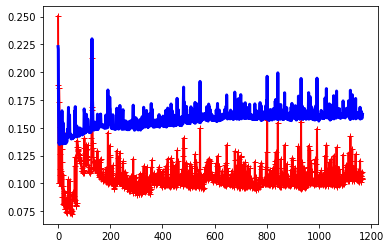

In [83]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)
    train_errors, val_errors = [], []
    for m in range (1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
        val_errors.append(mean_squared_error(y_val_predict,y_val))
    plt.plot(np.sqrt(train_errors),"r-+", linewidth = 2,label = "train")
    plt.plot(np.sqrt(val_errors),"b-", linewidth = 3,label = "val")
    
plot_learning_curves(NN_model, X, y)



In [84]:
batch_size = 64
epochs = 20
num_classes = 1

In [94]:
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import LeakyReLU
from keras.layers import Flatten
import keras
from keras.layers.core import Reshape


fashion_model = Sequential()

fashion_model.add(Reshape([X.shape[1],1], input_shape=(X.shape[1],)))
#print(fashion_model.input_shape)
#print(fashion_model.output_shape)
fashion_model.add(Conv1D(64,kernel_size=1,activation='selu',padding='valid'))
fashion_model.add(LeakyReLU(alpha=0.1))
print(fashion_model.input_shape)
print(fashion_model.output_shape)
fashion_model.add(MaxPooling1D(2, padding='same'))
fashion_model.add(Dropout(0.25))
print(fashion_model.output_shape)
fashion_model.add(Conv1D(128, 3, activation='selu',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling1D(pool_size=2,padding='same'))
fashion_model.add(Dropout(0.25))
print(fashion_model.output_shape)
fashion_model.add(Conv1D(256,  3, activation='selu',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))                  
fashion_model.add(MaxPooling1D(pool_size= 2,padding='same'))
fashion_model.add(Dropout(0.4))
print(fashion_model.output_shape)
fashion_model.add(Flatten())

fashion_model.add(Dense(128, activation='linear'))
fashion_model.add(LeakyReLU(alpha=0.1))           
fashion_model.add(Dropout(0.3)) 

print(fashion_model.output_shape)

fashion_model.add(Dense(1, kernel_initializer='normal', activation='linear'))



print(fashion_model.output_shape)

(None, 249)
(None, 249, 64)
(None, 125, 64)
(None, 63, 128)
(None, 32, 256)
(None, 128)
(None, 1)


In [95]:
fashion_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_28 (Reshape)         (None, 249, 1)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 249, 64)           128       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 249, 64)           0         
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 125, 64)           0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 125, 64)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 125, 128)          24704     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 125, 128)          0         
__________

In [99]:
fashion_model.compile(loss='mean_absolute_error', optimizer=keras.optimizers.Adam(),metrics=['mean_absolute_error'])

In [100]:
from keras.callbacks import ModelCheckpoint

checkpoint_name = "Weights-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint_name = "weights.best2.hdf5"
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')

callbacks_list = [EarlyStopping(monitor='val_loss', patience=20),checkpoint]

fashion_model.fit(X, y, epochs=50, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)



#fashion_train_dropout = fashion_model.fit(X_train, y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_val, y_val))

Train on 1168 samples, validate on 292 samples
Epoch 1/50
1168/1168 [==============================] - 6s 5ms/step - loss: 0.9692 - mean_absolute_error: 0.9692 - val_loss: 1.1465 - val_mean_absolute_error: 1.1465

Epoch 00001: val_loss improved from inf to 1.14646, saving model to weights.best2.hdf5
Epoch 2/50
1168/1168 [==============================] - 4s 4ms/step - loss: 0.6422 - mean_absolute_error: 0.6422 - val_loss: 1.3042 - val_mean_absolute_error: 1.3042

Epoch 00002: val_loss did not improve from 1.14646
Epoch 3/50
1168/1168 [==============================] - 5s 4ms/step - loss: 0.5981 - mean_absolute_error: 0.5981 - val_loss: 1.3357 - val_mean_absolute_error: 1.3357

Epoch 00003: val_loss did not improve from 1.14646
Epoch 4/50
1168/1168 [==============================] - 5s 4ms/step - loss: 0.6270 - mean_absolute_error: 0.6270 - val_loss: 0.9539 - val_mean_absolute_error: 0.9539

Epoch 00004: val_loss improved from 1.14646 to 0.95388, saving model to weights.best2.hdf5
Epoch

KeyboardInterrupt: 

In [92]:
X.shape

(1460, 249)

In [187]:
fashion_model.load_weights("weights.best2.hdf5")
fashion_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [188]:
housing_predictions = np.expm1(fashion_model.predict(X_test))
submission = pd.DataFrame(data=housing_predictions, index=housing_test.index , columns = ["SalePrice"])
submission.to_csv("sixteenth.csv")



In [2843]:
from sklearn.metrics import accuracy_score
y_pred = dnn_reg.predict_scores(X_val,as_iterable=False)
np.sqrt(metrics.mean_squared_error(y_val, y_pred))
#dnn_reg

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/px/w93bgkn51n782hwm_t45yrfr0000gn/T/tmp9ssq9d0i/model.ckpt-4000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


79507.20189803893

## Cross Validation NN

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(5)

from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.callbacks import EarlyStopping
from sklearn import metrics

oos_y = []
oos_pred = []
fold = 0
for train, test in kf.split(X):
    fold+=1
    print("Fold #{}".format(fold))

    x_train = X[train]
    y_train = y[train]
    x_test = X[test]
    y_test = y[test]

    model = Sequential()
    model.add(Dense(128, input_dim = X.shape[1], activation = "relu"))
    model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    
    
    model.add(Dense(1, kernel_initializer='normal',activation='linear'))
    model.compile(loss = 'mean_absolute_error', optimizer = 'adam',metrics=['mean_absolute_error'])

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3,patience=5, verbose=1, mode = 'auto')
    
    model.fit(x_train, y_train, validation_data = (x_test, y_test), callbacks = [monitor], verbose=0, epochs=1000)

    pred = model.predict(x_test)

    oos_y.append(y_test)
    oos_pred.append(pred)

    # Measure this fold's RMSE
    score = np.sqrt(metrics.mean_squared_error(pred, y_test))
    print("Fold score (MAE): {}".format(score))

#Build the oos predictions list and calculate hte error.
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
score = np.sqrt(metrics.mean_squared_error(oos_pred, oos_y))
print("Final, out of sample score (MAE): {}".format(score))

In [173]:
y_train.info()

AttributeError: 'Series' object has no attribute 'info'

In [81]:
import xgboost
from sklearn.model_selection import GridSearchCV

train_x=X_train
train_y=y_train

#for tuning parameters
parameters_for_testing = {
    'colsample_bytree':[0.4,0.6,0.8],
    'gamma':[0,0.03,0.1,0.3],
    'min_child_weight':[1.5,6,10],
    'learning_rate':[0.1,0.07],
    'max_depth':[3,5],
    #'n_estimators':[10000],
    'reg_alpha':[1e-5, 1e-2,  0.75],
    'reg_lambda':[1e-5, 1e-2, 0.45],
    'subsample':[0.6,0.95]  
}

                    
xgb_model = xgboost.XGBRegressor(learning_rate =0.1, max_depth=5,
     min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=6, scale_pos_weight=1, seed=42)

gsearch1 = GridSearchCV(estimator = xgb_model, param_grid = parameters_for_testing, n_jobs=6,iid=False, verbose=10,scoring='neg_mean_squared_error')
gsearch1.fit(train_x,train_y)
print (gsearch1.grid_scores_)
print('best params')
print (gsearch1.best_params_)
print('best score')
print (gsearch1.best_score_)

best_xgb_model = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)

best_xgb_model  = gsearch1.best_model_
best_xgb_model.fit(train_x,train_y)

Fitting 3 folds for each of 2592 candidates, totalling 7776 fits


/anaconda3/envs/py37/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   19.9s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   21.4s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:   33.8s
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:   42.9s
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   51.7s
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done 101 tasks      | elapsed:  2.

[14:30:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

In [92]:
best_xgb_model  = xgboost.XGBRegressor(colsample_bytree= 0.4, gamma= 0, learning_rate= 0.1, max_depth= 5, min_child_weight= 6, reg_alpha= 1e-05, reg_lambda= 1e-05, subsample= 0.95)

In [93]:
best_xgb_model.fit(train_x,train_y)

[14:40:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=6, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=1e-05, reg_lambda=1e-05, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.95, verbosity=1)

In [ ]:
best_xgb_model.fit(train)

In [94]:
housing_predictions = best_xgb_model.predict(X_test)
submission = pd.DataFrame(data=housing_predictions, index=housing_test.index , columns = ["SalePrice"])
submission.to_csv("sixteenth.csv")

## Fine-Tune Your Model

### Grid Search

In [157]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [10, 20, 50], 'max_features': [8, 16, 32, 50], 'max_depth': range(3,7)},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [10, 50], 'max_features': [12, 35, 50], 'max_depth': range(3,7)},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True, n_jobs=-1)
grid_search.fit(X, y.ravel())

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid=[{'max_depth': range(3, 7),
        

##### 

In [158]:
best_params = grid_search.best_params_
best_params

{'max_depth': 6, 'max_features': 16, 'n_estimators': 50}

In [162]:
housing_predictions = y_sc.inverse_transform(grid_search.predict(X_test).reshape(-1, 1))
submission = pd.DataFrame(data=housing_predictions, index=housing_test.index , columns = ["SalePrice"])
submission.to_csv("sixteenth.csv")


In [98]:

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

30913.383595306335 {'max_features': 16, 'n_estimators': 30}
29885.710551340697 {'max_features': 16, 'n_estimators': 180}
29804.895706659932 {'max_features': 16, 'n_estimators': 220}
29623.44049588345 {'max_features': 32, 'n_estimators': 30}
29113.57735572629 {'max_features': 32, 'n_estimators': 180}
29124.713165051042 {'max_features': 32, 'n_estimators': 220}
28871.628716456056 {'max_features': 64, 'n_estimators': 30}
28482.414668128367 {'max_features': 64, 'n_estimators': 180}
28418.086628620495 {'max_features': 64, 'n_estimators': 220}
27776.700974807867 {'max_features': 128, 'n_estimators': 30}
28626.952065100548 {'max_features': 128, 'n_estimators': 180}
28477.079882825867 {'max_features': 128, 'n_estimators': 220}
27862.29132290265 {'bootstrap': False, 'max_features': 128, 'n_estimators': 180}
27967.876015992235 {'bootstrap': False, 'max_features': 128, 'n_estimators': 220}
37969.727537186634 {'bootstrap': False, 'max_features': 254, 'n_estimators': 180}
37786.697306517475 {'boots

### Randomized Search

In [99]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(X_train, y_train)

/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [100]:

cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

33034.91023010842 {'max_features': 7, 'n_estimators': 180}
36036.54015238421 {'max_features': 5, 'n_estimators': 15}
36039.41629954901 {'max_features': 3, 'n_estimators': 72}
35486.21007196493 {'max_features': 5, 'n_estimators': 21}
33140.10566531342 {'max_features': 7, 'n_estimators': 122}
36051.80549175308 {'max_features': 3, 'n_estimators': 75}
35816.97244045075 {'max_features': 3, 'n_estimators': 88}
34269.895366105506 {'max_features': 5, 'n_estimators': 100}
35378.917107432346 {'max_features': 3, 'n_estimators': 150}
47995.15095524695 {'max_features': 5, 'n_estimators': 2}


{'max_features': 7, 'n_estimators': 180} produces smallest error of 33034.91023010842 

## Ensemble Methods

### Voting Classifiers

In [ ]:
VotingRegressor

In [290]:
from sklearn.ensemble import VotingRegressor

voting_reg = VotingRegressor(
    estimators = [('nn', NN_model),('ada',best_ada_reg)]
)
voting_reg.fit(X, y_train)

TypeError: Cannot clone object '<keras.engine.sequential.Sequential object at 0x1a639aad68>' (type <class 'keras.engine.sequential.Sequential'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' methods.

### Random Forests

In [101]:

from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=500, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [102]:

housing_predictions = forest_reg.predict(X_val)
forest_mse = mean_squared_error(y_val, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

34055.12928960105

In [103]:
forest_scores = cross_val_score(forest_reg, X, y,
                             scoring="neg_mean_squared_error", cv=5)
forest_rmse_scores = np.sqrt(-lin_scores)
display_scores(forest_rmse_scores)

Scores: [1.13741878e+14 3.98368469e+14 1.94591474e+14 1.43251278e+15
 1.58871493e+14 1.14792136e+15 2.51654797e+15 2.63992213e+14
 4.56895554e+04 2.55513560e+12]
Mean: 622910276810484.8
Standard deviation: 782757747573377.9


### Extra-Trees

In [104]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import ExtraTreeRegressor
from scipy.stats import randint

param_distribs = {
        #'max_depth': randint(low=3, high=200),
        #'max_features': randint(low=1, high=100),
        #'min_samples_leaf': randint(low=3, high=7),
        #'min_samples_split': randint(low=3, high=5),
    }

extra_forest_reg = ExtraTreeRegressor(random_state=42,max_depth=10, min_samples_leaf=4)
rnd_search = RandomizedSearchCV(extra_forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(X_train, y_train)

/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=ExtraTreeRegressor(criterion='mse', max_depth=10,
                                                max_features='auto',
                                                max_leaf_nodes=None,
                                                min_impurity_decrease=0.0,
                                                min_impurity_split=None,
                                                min_samples_leaf=4,
                                                min_samples_split=2,
                                                min_weight_fraction_leaf=0.0,
                                                random_state=42,
                                                splitter='random'),
                   iid='warn', n_iter=10, n_jobs=None, param_distributions={},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False, scoring='neg_mean_squared_error'

In [105]:

cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)
print("Best rnd search model's score: {}".format(np.min(np.sqrt(-cvres["mean_test_score"]))))

42179.022725023846 {}
Best rnd search model's score: 42179.022725023846


In [106]:
best_extra_forest_reg = rnd_search.best_estimator_

In [107]:

housing_predictions = best_extra_forest_reg.predict(X_val)
forest_mse = mean_squared_error(y_val, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

42366.92352608557

In [2815]:
#housing_predictions = best_extra_forest_reg.predict(X_test)
#submission = pd.DataFrame(data=housing_predictions, index=housing_test.index , columns = ["SalePrice"])
#submission.to_csv("sixth.csv")

### Boosting

In [276]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

ada_reg = AdaBoostRegressor(
    DecisionTreeRegressor(random_state=42,max_depth=14, min_samples_leaf=4), 
    random_state=42,
    #n_estimators=200,
    #learning_rate=0.5
)
ada_reg.fit(X, y)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                       max_depth=14,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=4,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=42,
                                                       splitter='best'),
                  learning_rate=1.0, loss='linear', n_estimators=50,
                  random_st

In [277]:
ada_reg.estimators_

[DecisionTreeRegressor(criterion='mse', max_depth=14, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=4,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort=False, random_state=1608637542, splitter='best'),
 DecisionTreeRegressor(criterion='mse', max_depth=14, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=4,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort=False, random_state=717137199, splitter='best'),
 DecisionTreeRegressor(criterion='mse', max_depth=14, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=4,
                       min_samples_split=2, min_weight_

In [278]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import ExtraTreeRegressor
from scipy.stats import randint, norm
import random

param_distribs = {
    'n_estimators': randint(low=1, high=200),
    'learning_rate': norm(0.5, 0.06),
}


rnd_search = RandomizedSearchCV(ada_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(X, y)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                                                    max_depth=14,
                                                                                    max_features=None,
                                                                                    max_leaf_nodes=None,
                                                                                    min_impurity_decrease=0.0,
                                                                                    min_impurity_split=None,
                                                                                    min_samples_leaf=4,
                                                                                    min_samples_split=2,
                                                                                    min_weight_fraction_le

In [279]:

cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)
print("Best rnd search model's score: ", np.min(np.sqrt(-cvres["mean_test_score"])))

27928.049904217038 {'learning_rate': 0.529802849180674, 'n_estimators': 107}
28334.31809856269 {'learning_rate': 0.49170414192972894, 'n_estimators': 72}
28194.904428857608 {'learning_rate': 0.43328719291718476, 'n_estimators': 75}
27844.48720096925 {'learning_rate': 0.519134131081363, 'n_estimators': 88}
27859.04548065165 {'learning_rate': 0.4468861792585043, 'n_estimators': 131}
27811.223209072363 {'learning_rate': 0.475268691171671, 'n_estimators': 150}
27679.76995296576 {'learning_rate': 0.5047899087329423, 'n_estimators': 158}
28355.997721027048 {'learning_rate': 0.49042900990057553, 'n_estimators': 38}
28043.48453613234 {'learning_rate': 0.5877426872207611, 'n_estimators': 89}
28549.84939781715 {'learning_rate': 0.5923228980568759, 'n_estimators': 49}
Best rnd search model's score:  27679.76995296576


In [280]:
best_ada_reg = rnd_search.best_estimator_
best_ada_reg

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                       max_depth=14,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=4,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=42,
                                                       splitter='best'),
                  learning_rate=0.5047899087329423, loss='linear',
                  n_estimator

In [281]:
housing_predictions = best_ada_reg.predict(X_val)
forest_mse = mean_squared_error(y_val, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

7267.163661476172

In [282]:
housing_predictions = best_ada_reg.predict(X_test)
submission = pd.DataFrame(data=housing_predictions, index=housing_test.index , columns = ["SalePrice"])
submission.to_csv("sixteenth.csv")

In [378]:
Z = best_ada_reg.predict(X).reshape(-1,1)

from keras import regularizers
from keras.layers.core import Dropout

NN1_model = Sequential()

# The Input Layer :
NN1_model.add(Dense(128, kernel_initializer='normal',input_dim = Z.shape[1], activation='relu'))

# The Hidden Layers :
NN1_model.add(Dense(256, kernel_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.01)))
NN1_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN1_model.add(Dropout(0.25))
NN1_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN1_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN1_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN1_model.summary()




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_219 (Dense)            (None, 128)               256       
_________________________________________________________________
dense_220 (Dense)            (None, 256)               33024     
_________________________________________________________________
dense_221 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_222 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_223 (Dense)            (None, 1)                 257       
Total params: 165,121
Trainable params: 165,121
Non-trainable params: 0
_________________________________________________________________


In [379]:
from keras.callbacks import ModelCheckpoint

checkpoint_name = "Weights-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint_name = "weights1.best.hdf5"
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]



In [380]:

NN1_model.fit(Z, y, epochs=50, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)


Train on 1168 samples, validate on 292 samples
Epoch 1/50
1168/1168 [==============================] - 6s 5ms/step - loss: 72268.2404 - mean_absolute_error: 72267.6727 - val_loss: 11052.8123 - val_mean_absolute_error: 11052.4403

Epoch 00001: val_loss improved from inf to 11052.81234, saving model to weights1.best.hdf5
Epoch 2/50
1168/1168 [==============================] - 1s 584us/step - loss: 11928.4349 - mean_absolute_error: 11928.1395 - val_loss: 5245.3540 - val_mean_absolute_error: 5245.1123

Epoch 00002: val_loss improved from 11052.81234 to 5245.35402, saving model to weights1.best.hdf5
Epoch 3/50
1168/1168 [==============================] - 1s 585us/step - loss: 10088.2664 - mean_absolute_error: 10088.0461 - val_loss: 11343.4792 - val_mean_absolute_error: 11343.2741

Epoch 00003: val_loss did not improve from 5245.35402
Epoch 4/50
1168/1168 [==============================] - 1s 636us/step - loss: 10756.7686 - mean_absolute_error: 10756.5695 - val_loss: 4044.2015 - val_mean_abs


Epoch 00034: val_loss did not improve from 3950.71538
Epoch 35/50
1168/1168 [==============================] - 1s 738us/step - loss: 10581.3391 - mean_absolute_error: 10581.1423 - val_loss: 10388.0539 - val_mean_absolute_error: 10387.8576

Epoch 00035: val_loss did not improve from 3950.71538
Epoch 36/50
1168/1168 [==============================] - 1s 750us/step - loss: 10061.7181 - mean_absolute_error: 10061.5215 - val_loss: 14335.5674 - val_mean_absolute_error: 14335.3711

Epoch 00036: val_loss did not improve from 3950.71538
Epoch 37/50
1168/1168 [==============================] - 1s 737us/step - loss: 9209.3389 - mean_absolute_error: 9209.1425 - val_loss: 6268.6412 - val_mean_absolute_error: 6268.4445

Epoch 00037: val_loss did not improve from 3950.71538
Epoch 38/50
1168/1168 [==============================] - 1s 708us/step - loss: 9403.1474 - mean_absolute_error: 9402.9511 - val_loss: 12874.6204 - val_mean_absolute_error: 12874.4241

Epoch 00038: val_loss did not improve from 39

In [382]:
NN1_model.load_weights("weights1.best.hdf5")
NN1_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])


housing_predictions = [(y)/2 for x, y in zip(NN_model.predict(X_test), NN1_model.predict(best_ada_reg.predict(X_test)))]
NN1_model.predict(best_ada_reg.predict(X_test))
submission = pd.DataFrame(data=housing_predictions, index=housing_test.index , columns = ["SalePrice"])
submission.to_csv("sixteenth.csv")

In [376]:
Z.shape

(1460, 1)

In [2841]:
#housing_predictions = best_ada_reg.predict(pca.transform(X_test))
#submission = pd.DataFrame(data=housing_predictions, index=housing_test.index , columns = ["SalePrice"])
#submission.to_csv("eighth.csv")

This is our best model so far

## Gradient Boosting

In [2795]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(random_state=42,max_depth=14, min_samples_leaf=4, max_features=200, n_estimators = 180, learning_rate = 0.01)
gbrt.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=14,
                          max_features=200, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=4, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=180,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [2796]:
housing_predictions = gbrt.predict(X_val)
forest_mse = mean_squared_error(y_val, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

80693.57340799087

In [2797]:
forest_scores = cross_val_score(gbrt, X, y,
                             scoring="neg_mean_squared_error", cv=5)
forest_rmse_scores = np.sqrt(-lin_scores)
display_scores(forest_rmse_scores)

Scores: [8.89255968e+13 7.50212988e+12 2.18756622e+13 1.38349977e+14
 7.75417793e+12 4.90635566e+14 3.55376789e+14 4.73205986e+14
 4.27044174e+04 2.52135128e+13]
Mean: 160883939742976.28
Standard deviation: 189837445637881.88


In [2344]:
gbrt = GradientBoostingRegressor(max_depth =2, warm_start=True)

min_val_error = float("inf")
error_going_up = 0 
for n_estimators in range(1,220):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up =0 
    else:
        error_going_up += 1
        if error_going_up == 40:
            break # early stopping


In [2345]:
bst_n_estimators = n_estimators
n_estimators

156

In [2346]:
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=156,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [2347]:
housing_predictions = best_extra_forest_reg.predict(X_val)
forest_mse = mean_squared_error(y_val, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

30494.00521767835

In [2732]:
forest_scores = cross_val_score(best_extra_forest_reg, X, y,
                             scoring="neg_mean_squared_error", cv=5)
forest_rmse_scores = np.sqrt(-lin_scores)
display_scores(forest_rmse_scores)

Scores: [8.89255968e+13 7.50212988e+12 2.18756622e+13 1.38349977e+14
 7.75417793e+12 4.90635566e+14 3.55376789e+14 4.73205986e+14
 4.27044174e+04 2.52135128e+13]
Mean: 160883939742976.28
Standard deviation: 189837445637881.88


## Clustering

In [ ]:

outliers_fraction = 0.01
random_state = 42

clf = CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state)





In [186]:
import pandas as pd
import numpy as np

# Import models
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF

from pyod.utils.data import get_outliers_inliers

outliers_fraction = 0.1



In [209]:
from pyod.models.knn import KNN
outliers_fraction = 0.01
random_state = 42

classifiers = {
    'Angle-based Outlier Detector (ABOD)'   : ABOD(contamination=outlier_fraction),
    'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state, n_clusters=3),
    'Isolation Forest': IForest(contamination=outliers_fraction/10,random_state=random_state),
    'K Nearest Neighbors (KNN)' :  KNN(contamination=outlier_fraction)
}

In [135]:

outliers_fraction = 0.01
random_state = 42

clf =  KNN(contamination=outlier_fraction)

clf.fit(X)

y_pred = clf.predict(X_reduced[:,0:2])

scores_pred = clf.decision_function(X_reduced[:,0:2]) * -1

CBLOF(alpha=0.9, beta=5, check_estimator=False, clustering_estimator=None,
   contamination=0.01, n_clusters=8, n_jobs=1, random_state=42,
   use_weights=False)

In [141]:
strat_test_set["outlier"]=clf.predict(X_val)
strat_train_set["outlier"]=clf.predict(X_train)
housing_test["outlier"] = clf.predict(X_test)

#strat_train_set, strat_test_set
X_train = full_pipeline.fit_transform(strat_train_set.drop("SalePrice", axis=1))
#y_train = housing_labels

X_val = full_pipeline.fit_transform(strat_test_set.drop("SalePrice", axis=1))
#y_val = strat_test_set["SalePrice"]

X = full_pipeline.fit_transform(pd.concat([strat_train_set, strat_test_set]))
#y = pd.concat([strat_train_set['SalePrice'], strat_test_set['SalePrice']])

X_test = full_pipeline.fit_transform(housing_test)

In [144]:
strat_test_set.shape

(292, 81)

## PCA

In [193]:
XX = X.drop(["CBLOFlabel", "outlier", 'Angle-based Outlier Detector (ABOD)', 'Cluster-based Local Outlier Factor (CBLOF)','Isolation Forest','K Nearest Neighbors (KNN)'], axis = 1)

In [194]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(XX)

In [ ]:

cmap = matplotlib.cm.get_cmap('viridis')
normalize = matplotlib.colors.Normalize(vmin=min(clusters), vmax=max(clusters))
colors = [cmap(normalize(value)) for value in clusters]

OUTLIERS :  165 INLIERS :  1288 Angle-based Outlier Detector (ABOD)


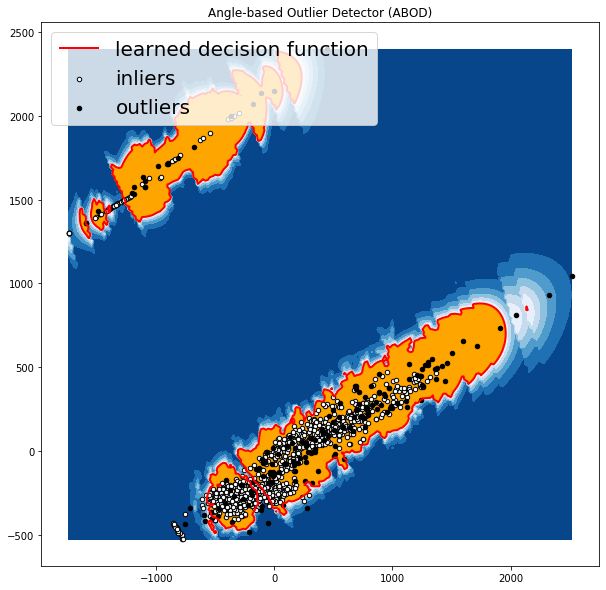

OUTLIERS :  15 INLIERS :  1438 Cluster-based Local Outlier Factor (CBLOF)


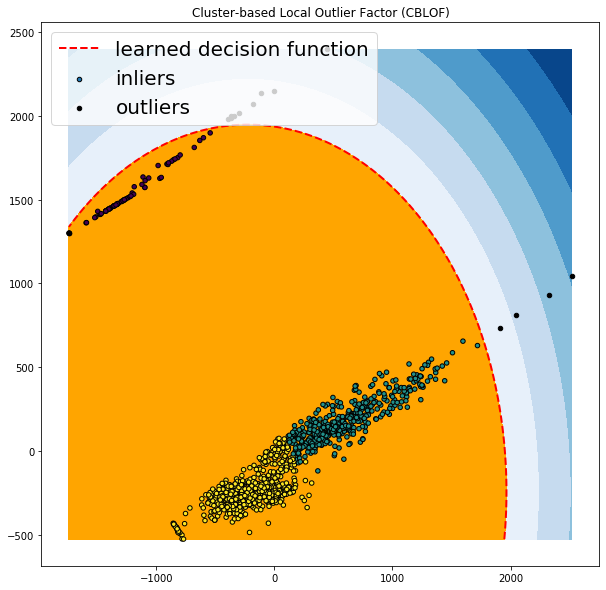

OUTLIERS :  2 INLIERS :  1451 Isolation Forest
(0.028978209729991655, 0.006961913059387943, 0.13000059769261563)


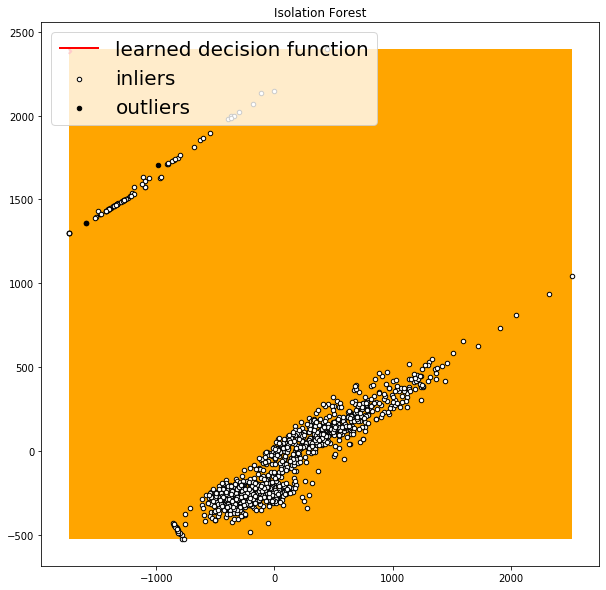

OUTLIERS :  125 INLIERS :  1328 K Nearest Neighbors (KNN)


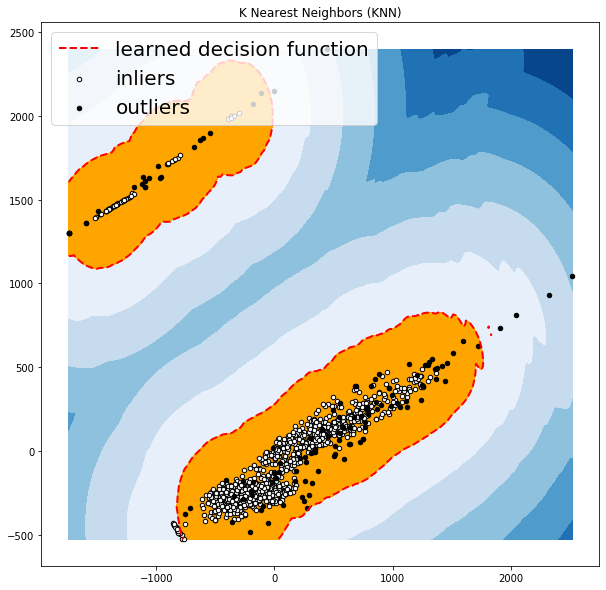

In [210]:
from scipy import stats

xx , yy = np.meshgrid(np.linspace(np.amin(X_reduced[:,0]), np.amax(X_reduced[:,0]),200), np.linspace(np.amin(X_reduced[:,1]), np.amax(X_reduced[:,1]), 200))

for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(XX)#X_reduced[:,0:2])
    # predict raw anomaly score
    scores_pred = clf.decision_function(XX)*-1#X_reduced[:,0:2]) * -1
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(XX)#X_reduced[:,0:2])
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    plt.figure(figsize=(10, 10))
    
    
    #dfx['outlier'] = y_pred.tolist()
    
    # IX1 - inlier feature 1,  IX2 - inlier feature 2
    IX1 =  X_reduced[y_pred == 0,0]#.reshape(-1,1)
    IX2 =  X_reduced[y_pred == 0,1]#.reshape(-1,1)
    try:
        colors = clf.cluster_labels_[y_pred == 0]
    except:
        colors = 'white'
    
    # OX1 - outlier feature 1, OX2 - outlier feature 2
    OX1 =  X_reduced[y_pred == 1,0]#.reshape(-1,1)
    OX2 =  X_reduced[y_pred == 1,1]#.reshape(-1,1)
         
    print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
        
    # threshold value to consider a datapoint inlier or outlier
    threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
        
    # decision function calculates the raw anomaly score for every point
    Z = clf.decision_function(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()])) * -1
    Z = Z.reshape(xx.shape)
          
    # fill blue map colormap from minimum anomaly score to threshold value
    try:
        plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
    except:
        print((Z.min(), threshold, Z.max()))
        plt.contourf(xx, yy, Z, levels=np.linspace(min(Z.min(), threshold),max(Z.min(), threshold), 7),cmap=plt.cm.Blues_r)
        
    
    # draw red contour line where anomaly score is equal to thresold
    a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
    # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
    plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
        
    b = plt.scatter(IX1,IX2, c=colors,s=20, edgecolor='k')
    
    c = plt.scatter(OX1,OX2, c='black',s=20, edgecolor='k')
       
    plt.axis('tight')  
    
    # loc=2 is used for the top left corner 
    plt.legend(
        [ a.collections[0],b,c],
        [ 'learned decision function', 'inliers','outliers'],
        prop=matplotlib.font_manager.FontProperties(size=20),
        loc=2)
      
    #plt.xlim((0, 1))
    #plt.ylim((0, 1))
    plt.title(clf_name)
    plt.show()

In [211]:
X_reduced[y_pred == 0,0].shape

(1328,)

In [92]:
xx.shape

(200, 200)

## PCA

In [216]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X_reduced = pca.fit_transform(XX)

<IPython.core.display.Javascript object>


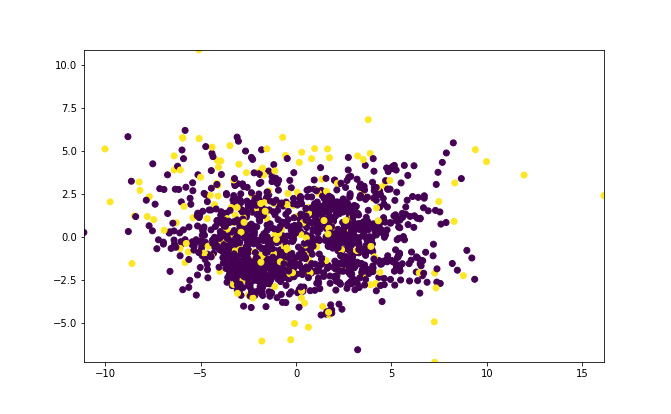

In [89]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=y_pred)
plt.axis([np.amin(X_reduced[:,0]), np.amax(X_reduced[:,0]), np.amin(X_reduced[:,1]), np.amax(X_reduced[:,1])])
plt.show()


In [155]:
np.amin(X_reduced[:,0]), np.amin(X_reduced[:,1])

(-11.422502325314484, -6.977818769365915)

<IPython.core.display.Javascript object>


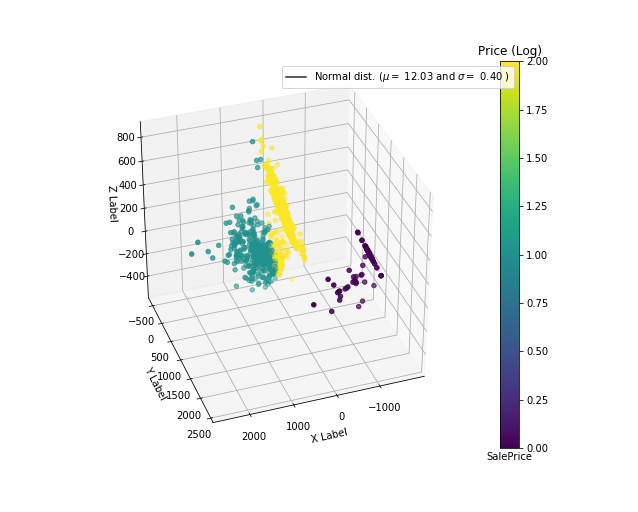

In [221]:
import matplotlib

%matplotlib notebook
import matplotlib.pyplot as plt

clf = CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state, n_clusters=3)
clf.fit(XX)

cmap = matplotlib.cm.get_cmap('viridis')
#normalize = matplotlib.colors.Normalize(vmin=min(clf.cluster_labels_), vmax=max(clf.cluster_labels_))
colors = [cmap(normalize(value)) for value in clf.cluster_labels_]


from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x =X_reduced[:,0]
yy =X_reduced[:,1]
z =X_reduced[:,2]


ax.scatter(x, yy,z, c=colors, marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

cax, _ = matplotlib.colorbar.make_axes(ax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)

plt.show()

In [218]:
min(y)

34900.0

In [216]:
max(y)

10.629458619203893